# 0. Package, Library, Mode

In [186]:
from pybaseball import statcast, cache
cache.enable()  # Ï∫êÏãú ÏÇ¨Ïö© ‚Üí Î∞òÎ≥µ Ìò∏Ï∂ú Î∞©ÏßÄ

import pandas as pd
import numpy as np

from IPython.display import display, HTML
from datetime import datetime, timedelta
import json, os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # ÏãúÍ∞ÅÌôî Ïãú Í≤ΩÍ≥† Î©îÏãúÏßÄ Ï†úÍ±∞
import shap

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, brier_score_loss, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint, mode
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier

In [187]:
# display option
pd.reset_option("all")

In [188]:
# EDITOR_MODE (vsc, colab) selection
EDITOR_MODE = 'vsc'

if EDITOR_MODE == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    # Colab ÌôòÍ≤ΩÏóêÏÑúÎäî Ïâò Î™ÖÎ†πÏñ¥Î°ú pip ÏÑ§Ïπò Í∞ÄÎä•
    !pip install -q pybaseball
    !pip install -q pyarrow
    !pip install -q xgboost
    !pip install -q lightgbm
    
elif EDITOR_MODE == 'vsc':
    pass

print("EDITOR_MODE : "+EDITOR_MODE)

EDITOR_MODE : vsc


# 1. Data Loader

In [189]:
COLAB_DATA_PATH = '/content/drive/MyDrive/'
VSC_DATA_PATH = '../data/'  # ÏÉÅÏúÑ Ìè¥Îçî

DATA_FILE_PATH = 'statcast_data.parquet'

INDICATOR_PATH = '../indicator/'  # ÏÉÅÏúÑ Ìè¥Îçî

if EDITOR_MODE == 'colab':
    file_path = COLAB_DATA_PATH + DATA_FILE_PATH
elif EDITOR_MODE == 'vsc':
    file_path = VSC_DATA_PATH + DATA_FILE_PATH
    
print("data path : "+file_path)

data path : ../data/statcast_data.parquet


In [190]:
# statcast data to parquet

'''
# APIÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Î∞õÏïÑÏÑú parquetÏúºÎ°ú Ï†ÄÏû•

years = [2025]
all_data = []

for year in years:
    start_date = f"{year}-03-29" 
    end_date = f"{year}-07-31"

    print(f"Fetching data for {year}...")
    year_data = statcast(start_dt=start_date, end_dt=end_date)
    year_data["season"] = year
    all_data.append(year_data)

data = pd.concat(all_data, ignore_index=True)

data.to_parquet(file_path)

print("Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å")


'''



'\n# APIÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Î∞õÏïÑÏÑú parquetÏúºÎ°ú Ï†ÄÏû•\n\nyears = [2025]\nall_data = []\n\nfor year in years:\n    start_date = f"{year}-03-29" \n    end_date = f"{year}-07-31"\n\n    print(f"Fetching data for {year}...")\n    year_data = statcast(start_dt=start_date, end_dt=end_date)\n    year_data["season"] = year\n    all_data.append(year_data)\n\ndata = pd.concat(all_data, ignore_index=True)\n\ndata.to_parquet(file_path)\n\nprint("Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å")\n\n\n'

In [191]:
print("data")
df = pd.read_parquet(file_path)
df

data


pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
0               SL 2024-03-29           85.4          -1.25           6.04   
1               FF 2024-03-29           96.1          -1.09           6.13   
2               FF 2024-03-29           95.6          -1.35           5.96   
3               FF 2024-03-29           95.3          -1.13           6.13   
4               SL 2024-03-29           87.1          -1.62           5.64   
...            ...        ...            ...            ...            ...   
1200615         SI 2025-08-07           93.9           1.23           5.38   
1200616         FF 2025-08-07           97.9          -1.74            6.1   
1200617         CH 2025-08-07           89.8           1.39           5.36   
1200618         FF 2025-08-07           98.2           -1.7           6.08   
1200619         SI 2025-08-07           94.1           1.28           5.38   

           player_name  batter  pitcher     events      description  ...  \
0          Adam, Jason  595281   592094       None  swinging_strike  ...   
1          Adam, Jason  672386   592094       None    called_strike  ...   
2          Adam, Jason  662139   592094       None             ball  ...   
3          Adam, Jason  457759   592094       None             ball  ...   
4         Parsons, Wes  664040   641149  field_out    hit_into_play  ...   
...                ...     ...      ...        ...              ...  ...   
1200615  Simpson, Josh  595777   681006       None             foul  ...   
1200616    P√©rez, Eury  595777   691587       None             foul  ...   
1200617  Simpson, Josh  595777   681006       None             foul  ...   
1200618    P√©rez, Eury  595777   691587       walk             ball  ...   
1200619  Simpson, Josh  595777   681006       walk             ball  ...   

         api_break_z_with_gravity  api_break_x_arm  api_break_x_batter_in  \
0                            3.24            -0.06                   0.06   
1                            0.86             0.82                   0.82   
2                            0.89             0.71                  -0.71   
3                            1.08             0.94                   0.94   
4                            2.68            -0.03                   0.03   
...                           ...              ...                    ...   
1200615                      2.14             1.36                  -1.36   
1200616                      1.04             0.41                  -0.41   
1200617                      2.93             1.09                  -1.09   
1200618                      1.01             1.09                  -1.09   
1200619                      2.09             0.98                  -0.98   

         arm_angle  attack_angle attack_direction swing_path_tilt  \
0             33.3          <NA>             <NA>            <NA>   
1             36.8          <NA>             <NA>            <NA>   
2             34.5          <NA>             <NA>            <NA>   
3             37.4          <NA>             <NA>            <NA>   
4             41.7          <NA>             <NA>            <NA>   
...            ...           ...              ...             ...   
1200615       <NA>     15.417441       -12.818561       28.456741   
1200616       <NA>     -2.941746        28.812731       24.006739   
1200617       <NA>     14.495103       -19.324361       35.643608   
1200618       <NA>          <NA>             <NA>            <NA>   
1200619       <NA>          <NA>             <NA>            <NA>   

        intercept_ball_minus_batter_pos_x_inches  \
0                                           <NA>   
1                                           <NA>   
2                                           <NA>   
3                                           <NA>   
4                                           <NA>   
...                                          ...   
1200615                               

In [192]:
# parquet update

'''
# ÏÇ¨Ïö©Ïûê ÏßÄÏ†ï Íµ¨Í∞Ñ
start_date = "2025-07-31"   # ÏÉà Îç∞Ïù¥ÌÑ∞ ÏãúÏûëÏùº
end_date   = "2025-08-08"   # ÏÉà Îç∞Ïù¥ÌÑ∞ Ï¢ÖÎ£åÏùº

# ÌååÏùº Í≤ΩÎ°ú (ÏúÑÏóêÏÑú ÎßåÎì† file_path Ïû¨ÏÇ¨Ïö©)
if not os.path.exists(file_path):
    raise FileNotFoundError(f"‚ö†Ô∏è {file_path} ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä Í∏∞Î≥∏ Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÏÑ∏Ïöî.")

# Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df_old = pd.read_parquet(file_path)
print(f"Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞: {df_old.shape} rows, {df_old['game_date'].min()} ~ {df_old['game_date'].max()}")

# ÏÉà Îç∞Ïù¥ÌÑ∞ Î∞õÏïÑÏò§Í∏∞
print(f"ÏÉà Îç∞Ïù¥ÌÑ∞ ÏöîÏ≤≠ Ï§ë... ({start_date} ~ {end_date})\n")
df_new = statcast(start_dt=start_date, end_dt=end_date)


if df_new.empty:
    print("‚ö†Ô∏è ÏÉà Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. Í∏∞Í∞ÑÏùÑ ÌôïÏù∏ÌïòÏÑ∏Ïöî.")
else:
    print(f"ÏÉà Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å: {df_new.shape} rows")

    # ÏãúÏ¶å Ïª¨Îüº Ï∂îÍ∞Ä (Í∏∞Ï°¥ ÌòïÏãù ÎßûÏ∂îÍ∏∞)
    df_new["season"] = pd.to_datetime(df_new["game_date"]).dt.year
    print(f"ÏãúÏ¶å Ïª¨Îüº Ï∂îÍ∞Ä: {df_new.shape} rows\n")

    # Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ÏôÄ Ìï©ÏπòÍ∏∞ + Ï§ëÎ≥µ Ï†úÍ±∞
    df_combined = pd.concat([df_old, df_new], ignore_index=True)

    # ÎÇ†ÏßúÏàú Ï†ïÎ†¨
    df_combined.sort_values(by=["game_date", "game_pk", "pitch_number"], inplace=True)

    # ÎçÆÏñ¥Ïì∞Í∏∞ Ï†ÄÏû•
    df_combined.to_parquet(file_path, index=False)
    print(f"‚úÖ Îç∞Ïù¥ÌÑ∞ ÏóÖÎç∞Ïù¥Ìä∏ ÏôÑÎ£å ‚Üí {file_path}")
    print(f"ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞: {df_combined.shape} rows, {df_combined['game_date'].min()} ~ {df_combined['game_date'].max()}")


'''

'\n# ÏÇ¨Ïö©Ïûê ÏßÄÏ†ï Íµ¨Í∞Ñ\nstart_date = "2025-07-31"   # ÏÉà Îç∞Ïù¥ÌÑ∞ ÏãúÏûëÏùº\nend_date   = "2025-08-08"   # ÏÉà Îç∞Ïù¥ÌÑ∞ Ï¢ÖÎ£åÏùº\n\n# ÌååÏùº Í≤ΩÎ°ú (ÏúÑÏóêÏÑú ÎßåÎì† file_path Ïû¨ÏÇ¨Ïö©)\nif not os.path.exists(file_path):\n    raise FileNotFoundError(f"‚ö†Ô∏è {file_path} ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä Í∏∞Î≥∏ Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÏÑ∏Ïöî.")\n\n# Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞\ndf_old = pd.read_parquet(file_path)\nprint(f"Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞: {df_old.shape} rows, {df_old[\'game_date\'].min()} ~ {df_old[\'game_date\'].max()}")\n\n# ÏÉà Îç∞Ïù¥ÌÑ∞ Î∞õÏïÑÏò§Í∏∞\nprint(f"ÏÉà Îç∞Ïù¥ÌÑ∞ ÏöîÏ≤≠ Ï§ë... ({start_date} ~ {end_date})\n")\ndf_new = statcast(start_dt=start_date, end_dt=end_date)\n\n\nif df_new.empty:\n    print("‚ö†Ô∏è ÏÉà Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. Í∏∞Í∞ÑÏùÑ ÌôïÏù∏ÌïòÏÑ∏Ïöî.")\nelse:\n    print(f"ÏÉà Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å: {df_new.shape} rows")\n\n    # ÏãúÏ¶å Ïª¨Îüº Ï∂îÍ∞Ä (Í∏∞Ï°¥ ÌòïÏãù ÎßûÏ∂îÍ∏∞)\n    df_new["season"] = pd.to_datetime(df_new["game_date"]).dt.year\n    print

In [193]:
print("data")
df = pd.read_parquet(file_path)
df = df.sort_values(by=["game_date", "game_pk", "pitch_number"], ascending=[True, True, True]).reset_index(drop=True)
df

data


pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
0               SL 2024-03-29           85.4          -1.25           6.04   
1               FF 2024-03-29           96.1          -1.09           6.13   
2               FF 2024-03-29           95.6          -1.35           5.96   
3               FF 2024-03-29           95.3          -1.13           6.13   
4               SL 2024-03-29           87.1          -1.62           5.64   
...            ...        ...            ...            ...            ...   
1200615         SI 2025-08-07           93.9           1.23           5.38   
1200616         FF 2025-08-07           97.9          -1.74            6.1   
1200617         CH 2025-08-07           89.8           1.39           5.36   
1200618         FF 2025-08-07           98.2           -1.7           6.08   
1200619         SI 2025-08-07           94.1           1.28           5.38   

           player_name  batter  pitcher     events      description  ...  \
0          Adam, Jason  595281   592094       None  swinging_strike  ...   
1          Adam, Jason  672386   592094       None    called_strike  ...   
2          Adam, Jason  662139   592094       None             ball  ...   
3          Adam, Jason  457759   592094       None             ball  ...   
4         Parsons, Wes  664040   641149  field_out    hit_into_play  ...   
...                ...     ...      ...        ...              ...  ...   
1200615  Simpson, Josh  595777   681006       None             foul  ...   
1200616    P√©rez, Eury  595777   691587       None             foul  ...   
1200617  Simpson, Josh  595777   681006       None             foul  ...   
1200618    P√©rez, Eury  595777   691587       walk             ball  ...   
1200619  Simpson, Josh  595777   681006       walk             ball  ...   

         api_break_z_with_gravity  api_break_x_arm  api_break_x_batter_in  \
0                            3.24            -0.06                   0.06   
1                            0.86             0.82                   0.82   
2                            0.89             0.71                  -0.71   
3                            1.08             0.94                   0.94   
4                            2.68            -0.03                   0.03   
...                           ...              ...                    ...   
1200615                      2.14             1.36                  -1.36   
1200616                      1.04             0.41                  -0.41   
1200617                      2.93             1.09                  -1.09   
1200618                      1.01             1.09                  -1.09   
1200619                      2.09             0.98                  -0.98   

         arm_angle  attack_angle attack_direction swing_path_tilt  \
0             33.3          <NA>             <NA>            <NA>   
1             36.8          <NA>             <NA>            <NA>   
2             34.5          <NA>             <NA>            <NA>   
3             37.4          <NA>             <NA>            <NA>   
4             41.7          <NA>             <NA>            <NA>   
...            ...           ...              ...             ...   
1200615       <NA>     15.417441       -12.818561       28.456741   
1200616       <NA>     -2.941746        28.812731       24.006739   
1200617       <NA>     14.495103       -19.324361       35.643608   
1200618       <NA>          <NA>             <NA>            <NA>   
1200619       <NA>          <NA>             <NA>            <NA>   

        intercept_ball_minus_batter_pos_x_inches  \
0                                           <NA>   
1                                           <NA>   
2                                           <NA>   
3                                           <NA>   
4                                           <NA>   
...                                          ...   
1200615                               

In [194]:
# date_match_dict

# ÎÇ†ÏßúÏôÄ Îß§Ïπò Ï†ïÎ≥¥ Ï∂îÏ∂ú
df['game_date'] = pd.to_datetime(df['game_date'])
df['date_str'] = df['game_date'].dt.strftime('%y%m%d')

# Îß§Ïπò ID: "AWAY@HOME" ÌòïÌÉúÎ°ú ÏÉùÏÑ±
df['match_id'] = df['away_team'] + "@" + df['home_team']

# ÎÇ†ÏßúÎ≥Ñ Îß§Ïπò ÏßëÌï© ÏÉùÏÑ±
date_match_dict = (
    df.groupby('date_str')['match_id']
    .agg(lambda x: sorted(set(x)))  # Ï†ïÎ†¨Îêú Î¶¨Ïä§Ìä∏Î°ú Ï†ÄÏû•
    .to_dict()
)



'''
# Ï†ÄÏû• Í≤ΩÎ°ú
match_json_path = "date_match_dict.json"

# JSONÏúºÎ°ú Ï†ÄÏû•
with open(match_json_path, "w") as f:
    json.dump(date_match_dict, f, indent=2)

print(f"‚úÖ Saved match list by date to {match_json_path}")
'''

'\n# Ï†ÄÏû• Í≤ΩÎ°ú\nmatch_json_path = "date_match_dict.json"\n\n# JSONÏúºÎ°ú Ï†ÄÏû•\nwith open(match_json_path, "w") as f:\n    json.dump(date_match_dict, f, indent=2)\n\nprint(f"‚úÖ Saved match list by date to {match_json_path}")\n'

In [195]:
print(type(date_match_dict))
# date_match_dict

<class 'dict'>


In [196]:
# pred_match_dict -> date_match_dict ÏóêÏÑú start, end Ï°∞Ï†àÌïòÍ≥† ÎÇ¥Ïùº Í≤ΩÍ∏∞ ÏÜêÏúºÎ°ú ÏßëÏñ¥ ÎÑ£ÏùÄ dict


# --- ÏÑ§Ï†ï ---
match_json_path = "date_match_dict.json"  # Í∏∞Ï°¥ Ï†ÑÏ≤¥ Îß§Ïπò JSON
pred_json_path = "pred_match_dict.json"   # Ï∂îÏ∂úÎêú Îß§Ïπò JSON

start_date = "250522"  # YYMMDD ÌòïÏãù
end_date   = "250807"  # YYMMDD ÌòïÏãù

# --- Î°úÎìú ---
with open(match_json_path, "r") as f:
    date_match_dict = json.load(f)

# --- ÌïÑÌÑ∞ÎßÅ ---
pred_match_dict = {
    date: matches
    for date, matches in date_match_dict.items()
    if start_date <= date <= end_date
}

# --- Ï†ÄÏû• ---
with open(pred_json_path, "w") as f:
    json.dump(pred_match_dict, f, indent=2, ensure_ascii=False)

print(f"‚úÖ Saved {len(pred_match_dict)} days of matches to {pred_json_path}")
print("ÎÇ†Ïßú Î≤îÏúÑ:", start_date, "~", end_date)



‚úÖ Saved 74 days of matches to pred_match_dict.json
ÎÇ†Ïßú Î≤îÏúÑ: 250522 ~ 250807


In [197]:
display(df)
# date_str, match_id Ï∂îÍ∞ÄÎê®

pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
0               SL 2024-03-29           85.4          -1.25           6.04   
1               FF 2024-03-29           96.1          -1.09           6.13   
2               FF 2024-03-29           95.6          -1.35           5.96   
3               FF 2024-03-29           95.3          -1.13           6.13   
4               SL 2024-03-29           87.1          -1.62           5.64   
...            ...        ...            ...            ...            ...   
1200615         SI 2025-08-07           93.9           1.23           5.38   
1200616         FF 2025-08-07           97.9          -1.74            6.1   
1200617         CH 2025-08-07           89.8           1.39           5.36   
1200618         FF 2025-08-07           98.2           -1.7           6.08   
1200619         SI 2025-08-07           94.1           1.28           5.38   

           player_name  batter  pitcher     events      description  ...  \
0          Adam, Jason  595281   592094       None  swinging_strike  ...   
1          Adam, Jason  672386   592094       None    called_strike  ...   
2          Adam, Jason  662139   592094       None             ball  ...   
3          Adam, Jason  457759   592094       None             ball  ...   
4         Parsons, Wes  664040   641149  field_out    hit_into_play  ...   
...                ...     ...      ...        ...              ...  ...   
1200615  Simpson, Josh  595777   681006       None             foul  ...   
1200616    P√©rez, Eury  595777   691587       None             foul  ...   
1200617  Simpson, Josh  595777   681006       None             foul  ...   
1200618    P√©rez, Eury  595777   691587       walk             ball  ...   
1200619  Simpson, Josh  595777   681006       walk             ball  ...   

         api_break_x_batter_in  arm_angle  attack_angle  attack_direction  \
0                         0.06       33.3          <NA>              <NA>   
1                         0.82       36.8          <NA>              <NA>   
2                        -0.71       34.5          <NA>              <NA>   
3                         0.94       37.4          <NA>              <NA>   
4                         0.03       41.7          <NA>              <NA>   
...                        ...        ...           ...               ...   
1200615                  -1.36       <NA>     15.417441        -12.818561   
1200616                  -0.41       <NA>     -2.941746         28.812731   
1200617                  -1.09       <NA>     14.495103        -19.324361   
1200618                  -1.09       <NA>          <NA>              <NA>   
1200619                  -0.98       <NA>          <NA>              <NA>   

         swing_path_tilt intercept_ball_minus_batter_pos_x_inches  \
0                   <NA>                                     <NA>   
1                   <NA>                                     <NA>   
2                   <NA>                                     <NA>   
3                   <NA>                                     <NA>   
4                   <NA>                                     <NA>   
...                  ...                                      ...   
1200615        28.456741                                31.030153   
1200616        24.006739                                40.662757   
1200617        35.643608                                26.186206   
1200618             <NA>                                     <NA>   
1200619             <NA>                                     <NA>   

        intercept_ball_minus_batter_pos_y_inches season date_str match_id  
0                                           <NA>   2024   240329   TOR@TB  
1                                           <NA>   2024   240329   TOR@TB  
2                                           <NA>   2024   240329   TOR@TB  
3                                           <NA>   2024   240329   TOR@TB  
4                     

# 2. Preprocessing

## 2-1 drop, fill, X y split

In [198]:
df_prepro = df.copy() 

In [199]:
# df features name print
def print_columns_in_blocks(df, block_size=5): 
    cols = df.columns.tolist()
    print(f"Ï¥ù Ïª¨Îüº Ïàò: {len(cols)}\n")

    for i in range(0, len(cols), block_size):
        print(", ".join(cols[i:i+block_size]))


print_columns_in_blocks(df)

Ï¥ù Ïª¨Îüº Ïàò: 121

pitch_type, game_date, release_speed, release_pos_x, release_pos_z
player_name, batter, pitcher, events, description
spin_dir, spin_rate_deprecated, break_angle_deprecated, break_length_deprecated, zone
des, game_type, stand, p_throws, home_team
away_team, type, hit_location, bb_type, balls
strikes, game_year, pfx_x, pfx_z, plate_x
plate_z, on_3b, on_2b, on_1b, outs_when_up
inning, inning_topbot, hc_x, hc_y, tfs_deprecated
tfs_zulu_deprecated, umpire, sv_id, vx0, vy0
vz0, ax, ay, az, sz_top
sz_bot, hit_distance_sc, launch_speed, launch_angle, effective_speed
release_spin_rate, release_extension, game_pk, fielder_2, fielder_3
fielder_4, fielder_5, fielder_6, fielder_7, fielder_8
fielder_9, release_pos_y, estimated_ba_using_speedangle, estimated_woba_using_speedangle, woba_value
woba_denom, babip_value, iso_value, launch_speed_angle, at_bat_number
pitch_number, pitch_name, home_score, away_score, bat_score
fld_score, post_away_score, post_home_score, post_bat_score, 

In [200]:
# df features missing rate csv
def save_missing_report_csv(df, filename, round_ndigits=2):
    # round_ndigits: Í≤∞Ï∏°Î•† Î∞òÏò¨Î¶º ÏûêÎ¶¨Ïàò (Í∏∞Î≥∏ 2)

    total_rows = len(df)
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / total_rows) * 100
    dtypes = df.dtypes
    sample_values = df.apply(lambda col: col.dropna().iloc[0] if col.dropna().size > 0 else None)

    report = pd.DataFrame({
        'Feature': df.columns,
        'Missing Count': missing_count.values,
        'Missing %': missing_percent.round(round_ndigits).values,
        'Dtype': dtypes.values,
        'Sample Value': sample_values.values
    })

    report.to_csv(INDICATOR_PATH + filename, index=False)
    print(f"Ï†ÄÏû• ÏôÑÎ£å: {filename} (Colab ÏôºÏ™Ω 'ÌååÏùºÌÉ≠'ÏóêÏÑú Îã§Ïö¥Î°úÎìú Í∞ÄÎä•)")
    
# save_missing_report_csv(df_prepro, filename="2-1 missing_report.csv")

In [201]:

# meta, drop Î∂ÑÎ¶¨
meta_features = [
    'game_pk',
    'inning', 'inning_topbot',
    'pitch_number',  # Ïù¥ ÌÉÄÏÑù ÎÇ¥ÏóêÏÑúÏùò Ìà¨Íµ¨ Î≤àÌò∏
    
    'home_team', 'away_team',
    'game_date',
    'batter', 'pitcher',
    'post_home_score', 'post_away_score',  # ÏµúÏ¢Ö Ï†êÏàò ‚Üí label
    'home_score', 'away_score',
    'events',
    
    'date_str', 'match_id'
]


drop_features = [
    #
    'player_name',
    'description',
    
    # ÏÇ¨Ïö©ÎêòÏßÄ ÏïäÎäî deprecated
    'spin_dir', 'spin_rate_deprecated',
    'break_angle_deprecated', 'break_length_deprecated',
    'tfs_deprecated', 'tfs_zulu_deprecated',
    
    #
    'des',
    'umpire',
    'sv_id',
    'pitcher_days_until_next_game', 'batter_days_until_next_game',
    
    # Ï§ëÎ≥µ ÎòêÎäî ÏùòÎØ∏ Ï§ëÎ≥µ
    'age_pit_legacy', 
    'age_bat_legacy', 
    'home_score_diff',

    # ÌÉÄÍ≤ü Ï†ïÎ≥¥ Ìè¨Ìï® Í∞ÄÎä•ÏÑ± (Îç∞Ïù¥ÌÑ∞ ÎàÑÏàò Ïö∞Î†§)
    'post_bat_score', 'post_fld_score',
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp',
    'home_win_exp', 'bat_win_exp',
    'bat_score', 'fld_score',
    
    # Îã®Ïùº ÏãúÏ¶å ÌõàÎ†® Ïãú Î∂àÌïÑÏöî
    'game_year', 'season',
    
    # fielder
    'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
    
    # drop by missing (missing over 50%)
    'hit_location', 'bb_type',
    'on_3b', 'on_2b', 'on_1b',
    'hc_x', 'hc_y',
    'hit_distance_sc',
    'launch_speed', 'launch_angle', 'launch_speed_angle',
    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
    'woba_value', 'woba_denom',
    'babip_value', 'iso_value',
    'bat_speed',
    'swing_length',
    'estimated_slg_using_speedangle',
    'hyper_speed',
    'attack_angle', 'attack_direction',
    'swing_path_tilt',
    'intercept_ball_minus_batter_pos_x_inches', 'intercept_ball_minus_batter_pos_y_inches',
    
    # 
    
]



print("meta_features len : " + str(len(meta_features)))
print("drop_features len : " + str(len(drop_features)))

meta_features len : 16
drop_features len : 61


In [202]:
def preprocess_X_meta_y(df_prepro, meta_features, drop_features):
    # 1. meta
    df_meta = df_prepro[meta_features].copy()
    
    # 2. X
    df_drop = df_prepro.drop(columns=meta_features + drop_features)

    # 3. y
    
    def assign_label(row):
        if row['post_home_score'] > row['post_away_score']:
            return 1   # Ìôà Ïäπ
        elif row['post_home_score'] < row['post_away_score']:
            return 0   # ÏõêÏ†ï Ïäπ
        else:
            return 1   # Î¨¥ÏäπÎ∂ÄÎäî Ìôà Ïäπ Ï≤òÎ¶¨
        
    y = df_meta.groupby('game_pk').agg({
        'date_str': 'first',
        'match_id': 'first',
        
        'home_team': 'first',
        'away_team': 'first',
        
        'post_home_score': 'max',
        'post_away_score': 'max',
    }).reset_index()
    
    y['label'] = y.apply(assign_label, axis=1)
    
    return df_drop, df_meta, y

# X, y(label) split
X, meta, y = preprocess_X_meta_y(df_prepro, meta_features, drop_features)

In [203]:
# metaÏóêÏÑú Í≥†Ïú† game_pk ÏàúÏÑú Î¶¨Ïä§Ìä∏
game_pk_order = meta['game_pk'].drop_duplicates().tolist()

# df_yÎ•º game_pk ÏàúÏÑúÏóê ÎßûÏ∂∞ Ïû¨Ï†ïÎ†¨
y = y.set_index('game_pk').loc[game_pk_order].reset_index()

In [204]:
# X, meta, y    shape
dataset_shapes = {
    "df": (X, meta, y),
}

# Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
summary = []

# Í∞Å Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌï¥ shape Ï†ïÎ≥¥ ÏàòÏßë
for name, (X, meta, y) in dataset_shapes.items():
    summary.append({
        "Set": name,
        "X Shape": X.shape,
        "Meta Shape": meta.shape,
        "y Shape": y.shape
    })

# DataFrameÏúºÎ°ú Ï†ïÎ¶¨Ìï¥ÏÑú Ï∂úÎ†•
shape_df = pd.DataFrame(summary)
display(shape_df)


Set        X Shape     Meta Shape    y Shape
0  df  (1200620, 44)  (1200620, 16)  (4115, 8)

In [205]:
# df meta excel

'''
# ÏÉÅÏúÑ 10Í∞ú ÏÉòÌîåÏùÑ ÎΩëÍ∏∞
sample_count = 10
meta_samples = {}

for col in meta.columns:
    meta_samples[col] = list(meta[col].head(sample_count))

# DataFrameÏúºÎ°ú Î≥ÄÌôò
df_meta_samples = pd.DataFrame(meta_samples)

# ‚úÖ ÏóëÏÖÄÎ°ú Ï†ÄÏû• (ÏõêÌïòÎ©¥)
output_path = INDICATOR_PATH+"2-1 meta_sample_10.xlsx"
df_meta_samples.to_excel(output_path, index=False)
'''

'\n# ÏÉÅÏúÑ 10Í∞ú ÏÉòÌîåÏùÑ ÎΩëÍ∏∞\nsample_count = 10\nmeta_samples = {}\n\nfor col in meta.columns:\n    meta_samples[col] = list(meta[col].head(sample_count))\n\n# DataFrameÏúºÎ°ú Î≥ÄÌôò\ndf_meta_samples = pd.DataFrame(meta_samples)\n\n# ‚úÖ ÏóëÏÖÄÎ°ú Ï†ÄÏû• (ÏõêÌïòÎ©¥)\noutput_path = INDICATOR_PATH+"2-1 meta_sample_10.xlsx"\ndf_meta_samples.to_excel(output_path, index=False)\n'

In [206]:
# df y excel

'''
output_path = INDICATOR_PATH + "2-1 y_summary.xlsx"
y.to_excel(output_path, index=False)
'''


'\noutput_path = INDICATOR_PATH + "2-1 y_summary.xlsx"\ny.to_excel(output_path, index=False)\n'

In [207]:
def check_topbot_pairing(meta, name):
    counts = meta.groupby("game_pk")["inning_topbot"].nunique()
    result = {
        "Set": name,
        "Total Games": len(counts),
        "Both Top/Bottom": (counts == 2).sum(),
        "Only Top or Bottom": (counts < 2).sum()
    }
    return result


# Î™®Îì† ÏÑ∏Ìä∏ Í≤ÄÏÇ¨
topbot_summary = pd.DataFrame([
    check_topbot_pairing(meta, "df")
])


# Ìëú ÌòïÌÉúÎ°ú Ï∂úÎ†•
display(topbot_summary)

Set  Total Games  Both Top/Bottom  Only Top or Bottom
0  df         4115             4115                   0

In [208]:
# label ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
label_1_count = (y['label'] == 1).sum()
label_0_count = (y['label'] == 0).sum()
label_1_pct = (label_1_count / len(y)) * 100
label_0_pct = (label_0_count / len(y)) * 100

# Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Ï†ïÎ¶¨
stats_df = pd.DataFrame({
    'Metric': ['y_shape', 'label_1_count', 'label_0_count', 'label_1_pct', 'label_0_pct'],
    'Value': [f"{y.shape[0]} x {y.shape[1]}", label_1_count, label_0_count, f"{label_1_pct:.2f}%", f"{label_0_pct:.2f}%"]
})

# Ìëú ÌòïÌÉúÎ°ú Ï∂úÎ†•
display(stats_df)


Metric     Value
0        y_shape  4115 x 8
1  label_1_count      2188
2  label_0_count      1927
3    label_1_pct    53.17%
4    label_0_pct    46.83%

In [209]:
print_columns_in_blocks(X)

Ï¥ù Ïª¨Îüº Ïàò: 44

pitch_type, release_speed, release_pos_x, release_pos_z, zone
game_type, stand, p_throws, type, balls
strikes, pfx_x, pfx_z, plate_x, plate_z
outs_when_up, vx0, vy0, vz0, ax
ay, az, sz_top, sz_bot, effective_speed
release_spin_rate, release_extension, release_pos_y, at_bat_number, pitch_name
if_fielding_alignment, of_fielding_alignment, spin_axis, bat_score_diff, age_pit
age_bat, n_thruorder_pitcher, n_priorpa_thisgame_player_at_bat, pitcher_days_since_prev_game, batter_days_since_prev_game
api_break_z_with_gravity, api_break_x_arm, api_break_x_batter_in, arm_angle


In [210]:
# X fill

X_missing = X

# 1) ÌèâÍ∑†ÏúºÎ°ú Ï±ÑÏö∞Îäî Ïª¨Îüº
fill_mean_cols = [
    'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
    'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
    'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate',
    'release_extension', 'release_pos_y', 'spin_axis', 'api_break_z_with_gravity',
    'api_break_x_arm', 'api_break_x_batter_in', 'arm_angle'
]

for col in fill_mean_cols:
    mean_val = X_missing[col].mean()
    # Int64 ÌÉÄÏûÖÏùÄ Ï†ïÏàòÎ°ú Î≥ÄÌôò ÌõÑ fill
    if pd.api.types.is_integer_dtype(X_missing[col].dtype):
        mean_val = int(round(mean_val))

    X_missing[col].fillna(mean_val, inplace=True)


# 2) ÏµúÎπàÍ∞íÏúºÎ°ú Ï±ÑÏö∞Îäî Ïª¨Îüº
fill_mode_cols = ['zone']
for col in fill_mode_cols:
    mode_val = X_missing[col].mode().iloc[0]

    X_missing[col].fillna(mode_val, inplace=True)


# 3) 'Unknown' ÎòêÎäî ÏµúÎπàÍ∞íÏúºÎ°ú Ï±ÑÏö∞Îäî object ÌÉÄÏûÖ Ïª¨Îüº
fill_unknown_cols = ['pitch_type', 'pitch_name']
for col in fill_unknown_cols:
    X_missing[col].fillna('Unknown', inplace=True)


# 4) Í≥†Ï†ïÍ∞íÏúºÎ°ú Ï±ÑÏö∞Îäî Ïª¨Îüº
fill_constant = {
    'if_fielding_alignment': 'Standard',
    'of_fielding_alignment': 'Standard',
    'pitcher_days_since_prev_game': 0,
    'batter_days_since_prev_game': 0
}

for col, val in fill_constant.items():
    X_missing[col].fillna(val, inplace=True)


# Í≥†Ï†ïÍ∞í Ïª¨Îüº Î¶¨Ïä§Ìä∏ Ï†ïÏùò (keysÎßå ÏÇ¨Ïö©)
fill_constant_cols = list(fill_constant.keys())

# Ï¥ù Ïª¨Îüº Í∞úÏàò Í≥ÑÏÇ∞
total_fill_cols = len(fill_mean_cols + fill_mode_cols + fill_unknown_cols + fill_constant_cols)
print("filled len :", total_fill_cols)


filled len : 31


In [211]:
# X_missing -> fill check (Í≤∞Ï∏°Ïπò Ï†ÑÎ∂Ä 0Ïù∏ÏßÄ ÌôïÏù∏)
datasets = {
    "X_missing": X_missing,
}

# Í≤∞Ï∏°ÏπòÍ∞Ä Î™®Îëê 0Í∞úÏù∏ÏßÄ ÌôïÏù∏
for name, df in datasets.items():
    missing_per_col = df.isnull().sum()
    if (missing_per_col == 0).all():
        print(f"{name} every feature missing 0%")
    else:
        print(f"{name} has missing values:")
        print(missing_per_col[missing_per_col > 0])


X_missing every feature missing 0%


In [212]:
# X_missing 10 sample 

sample_data = []

# Í∞Å Ïª¨ÎüºÎ≥Ñ ÏÉÅÏúÑ 10Í∞ú ÏÉòÌîå Ï∂îÏ∂ú
for col in X_missing.columns:
    top_samples = X_missing[col].head(10).tolist()  # ÏÉÅÏúÑ 10Í∞ú Í∞í
    sample_data.append([col] + top_samples)

# DataFrameÏúºÎ°ú Î≥ÄÌôò
# Ï≤´ Î≤àÏß∏ Ïª¨ÎüºÏùÄ 'column_name', Ïù¥ÌõÑÎäî sample_1, sample_2, ...
sample_df = pd.DataFrame(sample_data, columns=['column_name'] + [f'sample_{i+1}' for i in range(10)])

# ExcelÎ°ú Ï†ÄÏû•
output_file = INDICATOR_PATH + "2-1 X_missing_top10_samples.xlsx"
sample_df.to_excel(output_file, index=False)

## 2-2 Encoding

In [213]:
# Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ± (ÏõêÎ≥∏ Î≥¥Ï°¥)
X_encoded = X_missing.copy()

In [214]:
# 1. Label Encoding (Í≥µÌÜµ)

# Ïù∏ÏΩîÎî©Ìï† Ïª¨Îüº Î™©Î°ù
label_encode_cols = ['pitch_type', 'type', 'zone', 'pitch_name']


# 1. Ïù∏ÏΩîÎî© Ï†Ñ Îç∞Ïù¥ÌÑ∞ Î≥µÏÇ¨ (Before Ï†ÄÏû•Ïö©)
X_encoded = X_missing.copy()  # X_missingÏóêÏÑú fillÎêú Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©
before_samples = X_encoded[label_encode_cols].copy()

# 2. Î¨∏ÏûêÏó¥ Î≥ÄÌôò (Ïπ¥ÌÖåÍ≥†Î¶¨Í∞Ä Ïà´ÏûêÎ°ú Î∞îÎÄåÎäî Î¨∏Ï†ú Î∞©ÏßÄ)
for col in label_encode_cols:
    X_encoded[col] = X_encoded[col].astype(str)

# 3. OrdinalEncoderÎ°ú Ïù∏ÏΩîÎî©
# OrdinalEncoder Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ± (unknown ‚Üí -1Î°ú Ï≤òÎ¶¨)
# fit + transform (Ï†ÑÏ≤¥ X_encoded Í∏∞Ï§Ä)
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded[label_encode_cols] = ordinal_enc.fit_transform(X_encoded[label_encode_cols])


# Label Encoding excel
'''
# 4. Sheet1: Before-After ÎπÑÍµê (ÏÉÅÏúÑ 10Í∞ú)
sample_count = 10
compare_df = pd.DataFrame()

for col in label_encode_cols:
    compare_df[f"{col} (before)"] = before_samples[col].head(sample_count).values
    compare_df[f"{col} (after)"] = X_encoded[col].head(sample_count).astype(int).values


# 5. Sheet2~Sheet5: Í∞Å Ïª¨ÎüºÎ≥Ñ Îß§Ìïë ÌÖåÏù¥Î∏î
mapping_dfs = {}
for i, col in enumerate(label_encode_cols):
    mapping_dfs[col] = pd.DataFrame({
        "category": ordinal_enc.categories_[i],
        "encoded_value": range(len(ordinal_enc.categories_[i]))
    })

# 6. ExcelÎ°ú Ï†ÄÏû•
with pd.ExcelWriter(INDICATOR_PATH+"2-2 label_encoding_summary.xlsx") as writer:
    compare_df.to_excel(writer, sheet_name="Before_After_Sample", index=False)
    for col in label_encode_cols:
        mapping_dfs[col].to_excel(writer, sheet_name=f"Mapping_{col}", index=False)
'''


'\n# 4. Sheet1: Before-After ÎπÑÍµê (ÏÉÅÏúÑ 10Í∞ú)\nsample_count = 10\ncompare_df = pd.DataFrame()\n\nfor col in label_encode_cols:\n    compare_df[f"{col} (before)"] = before_samples[col].head(sample_count).values\n    compare_df[f"{col} (after)"] = X_encoded[col].head(sample_count).astype(int).values\n\n\n# 5. Sheet2~Sheet5: Í∞Å Ïª¨ÎüºÎ≥Ñ Îß§Ìïë ÌÖåÏù¥Î∏î\nmapping_dfs = {}\nfor i, col in enumerate(label_encode_cols):\n    mapping_dfs[col] = pd.DataFrame({\n        "category": ordinal_enc.categories_[i],\n        "encoded_value": range(len(ordinal_enc.categories_[i]))\n    })\n\n# 6. ExcelÎ°ú Ï†ÄÏû•\nwith pd.ExcelWriter(INDICATOR_PATH+"2-2 label_encoding_summary.xlsx") as writer:\n    compare_df.to_excel(writer, sheet_name="Before_After_Sample", index=False)\n    for col in label_encode_cols:\n        mapping_dfs[col].to_excel(writer, sheet_name=f"Mapping_{col}", index=False)\n'

In [215]:
'''
fit()
ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Ï§ÄÏúºÎ°ú ÎùºÎ≤® Ïù∏ÏΩîÎî©Ïùò Îß§Ìïë Í∑úÏπôÏùÑ ÎßåÎì†Îã§
Ïòà: ['FF', 'SL', 'CU'] ‚Üí [0, 1, 2]

transform()
Ïù¥ÎØ∏ ÎßåÎì† Îß§Ìïë Í∑úÏπôÏùÑ Ïù¥Ïö©Ìï¥ÏÑú Ïã§Ï†ú Í∞íÏùÑ Î≥ÄÌôòÌïúÎã§
Ïòà: 'SL' ‚Üí 1
'''

"\nfit()\nÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Ï§ÄÏúºÎ°ú ÎùºÎ≤® Ïù∏ÏΩîÎî©Ïùò Îß§Ìïë Í∑úÏπôÏùÑ ÎßåÎì†Îã§\nÏòà: ['FF', 'SL', 'CU'] ‚Üí [0, 1, 2]\n\ntransform()\nÏù¥ÎØ∏ ÎßåÎì† Îß§Ìïë Í∑úÏπôÏùÑ Ïù¥Ïö©Ìï¥ÏÑú Ïã§Ï†ú Í∞íÏùÑ Î≥ÄÌôòÌïúÎã§\nÏòà: 'SL' ‚Üí 1\n"

In [216]:
print(X_encoded.shape)

(1200620, 44)


In [217]:
# 2. One-Hot Encoding
one_hot_cols = ['game_type', 'stand', 'p_throws', 'if_fielding_alignment', 'of_fielding_alignment']

# 1) Ï†ÑÏ≤¥ Í∞ÄÎä•Ìïú dummy Ïª¨Îüº Ï∂îÏ∂ú (Í∏∞Ï§Ä: X_encoded Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞)
dummy_all_columns = pd.get_dummies(X_encoded[one_hot_cols], columns=one_hot_cols).columns.tolist()

# 2) X_encodedÏóê ÎåÄÌï¥ One-Hot Encoding ÏàòÌñâ
df_dummies = pd.get_dummies(X_encoded[one_hot_cols], columns=one_hot_cols)

# 3) ÎàÑÎùΩÎêú Ïª¨Îüº Î≥¥Ï†ï (0ÏúºÎ°ú Ï±ÑÏö∞Í∏∞)
for col in dummy_all_columns:
    if col not in df_dummies.columns:
        df_dummies[col] = 0

# 4) Ïª¨Îüº ÏàúÏÑú ÎßûÏ∂§
df_dummies = df_dummies[dummy_all_columns]

# 5) Í∏∞Ï°¥ ÏõêÎ≥∏ÏóêÏÑú one_hot_cols ÏÇ≠Ï†úÌïòÍ≥†, Ïù∏ÏΩîÎî© Í≤∞Í≥º Ìï©ÏπòÍ∏∞
X_encoded = pd.concat([X_encoded.drop(columns=one_hot_cols), df_dummies], axis=1)


print(X_encoded.shape)

# ÎìúÎ°≠ ÎåÄÏÉÅ Ïª¨Îüº (Ìù¨Í∑Ä + Î∂àÍ∑†Ìòï)
rare_alignment_cols = [
    'if_fielding_alignment_Infield shade',
    # ÏùòÎØ∏ : ÎØ∏ÏÑ∏Ìïú ÎÇ¥Ïïº ÏúÑÏπò Ï°∞Ï†ï
    # ÎπàÎèÑ : Ìù¨Í∑Ä	
    # Ï§ëÏöîÎèÑ : ÎÇÆÏùå
    'of_fielding_alignment_4th outfielder'
    # 4Î™Ö Ïô∏ÏïºÏàò Î∞∞Ïπò (Ï†ÑÎûµÏ†Å)	
    # Îß§Ïö∞ Ìù¨Í∑Ä	
    # Îß§Ïö∞ ÎÇÆÏùå 
]

X_encoded.drop(columns=rare_alignment_cols, errors='ignore', inplace=True)
print(f"‚úÖ One-Hot Encoding ÏôÑÎ£å (Ìù¨Í∑Ä Ïª¨Îüº Ï†úÍ±∞ ÌõÑ): {X_encoded.shape}")


# One-Hot Encoding excel
'''
# One-Hot Encoding ÌôïÏù∏
# (1) Sheet1: One-Hot Encoding Ï†Ñ 10Í∞ú ÏÉòÌîå
sheet1 = X_missing[one_hot_cols].head(10).copy()

# (2) Sheet2: One-Hot Encoding ÌõÑ 10Í∞ú ÏÉòÌîå
sheet2 = df_dummies.drop(columns=rare_alignment_cols, errors='ignore').head(10).copy()

# ExcelÎ°ú Ï†ÄÏû•
with pd.ExcelWriter(INDICATOR_PATH+"2-2 onehot_encoding_summary.xlsx") as writer:
    sheet1.to_excel(writer, sheet_name="Before_OneHot", index=False)
    sheet2.to_excel(writer, sheet_name="After_OneHot", index=False)

print("‚úÖ One-Hot Encoding ÎπÑÍµê Í≤∞Í≥º Ï†ÄÏû• ÏôÑÎ£å ‚Üí onehot_encoding_summary.xlsx")
'''

(1200620, 50)
‚úÖ One-Hot Encoding ÏôÑÎ£å (Ìù¨Í∑Ä Ïª¨Îüº Ï†úÍ±∞ ÌõÑ): (1200620, 48)


'\n# One-Hot Encoding ÌôïÏù∏\n# (1) Sheet1: One-Hot Encoding Ï†Ñ 10Í∞ú ÏÉòÌîå\nsheet1 = X_missing[one_hot_cols].head(10).copy()\n\n# (2) Sheet2: One-Hot Encoding ÌõÑ 10Í∞ú ÏÉòÌîå\nsheet2 = df_dummies.drop(columns=rare_alignment_cols, errors=\'ignore\').head(10).copy()\n\n# ExcelÎ°ú Ï†ÄÏû•\nwith pd.ExcelWriter(INDICATOR_PATH+"2-2 onehot_encoding_summary.xlsx") as writer:\n    sheet1.to_excel(writer, sheet_name="Before_OneHot", index=False)\n    sheet2.to_excel(writer, sheet_name="After_OneHot", index=False)\n\nprint("‚úÖ One-Hot Encoding ÎπÑÍµê Í≤∞Í≥º Ï†ÄÏû• ÏôÑÎ£å ‚Üí onehot_encoding_summary.xlsx")\n'

In [218]:
'''
pd.get_dummies()Îäî Ï£ºÏñ¥ÏßÑ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï°¥Ïû¨ÌïòÎäî Í∞íÎì§Îßå Í∏∞Ï§ÄÏúºÎ°ú One-Hot EncodingÏùÑ ÏàòÌñâ

**stand**Îäî ÏõêÎûò Ïª¨Îüº Ïù¥Î¶ÑÏù¥Í≥†,
**stand_L, stand_R**  Îäî Ï†ëÎëêÏÇ¨(prefix)Î°ú ÏÇ¨Ïö©ÎêòÏñ¥ ÎßåÎì§Ïñ¥ÏßÑ Í≤∞Í≥º Ïª¨Îüº
'''

'''
encoded_cols = [col for col in X_train_encoded.columns if col.startswith(prefix + '_')]
[<Î∞òÌôòÌï† Ìï≠Î™©> for <Ìï≠Î™©> in <Î∞òÎ≥µ ÎåÄÏÉÅ> if <Ï°∞Í±¥>]


if col.startswith(prefix + '_')
Ïù¥ Î∂ÄÎ∂ÑÏùÄ Í∞Å Ïª¨Îüº Ïù¥Î¶ÑÏù¥ ÌäπÏ†ï Ï†ëÎëêÏÇ¨Î°ú ÏãúÏûëÌïòÎäîÏßÄ ÌôïÏù∏Ìï©ÎãàÎã§.

'stand_L'.startswith('stand_')  # True
'stand_R'.startswith('stand_')  # True
'pitch_type'.startswith('stand_')  # False
'''

"\nencoded_cols = [col for col in X_train_encoded.columns if col.startswith(prefix + '_')]\n[<Î∞òÌôòÌï† Ìï≠Î™©> for <Ìï≠Î™©> in <Î∞òÎ≥µ ÎåÄÏÉÅ> if <Ï°∞Í±¥>]\n\n\nif col.startswith(prefix + '_')\nÏù¥ Î∂ÄÎ∂ÑÏùÄ Í∞Å Ïª¨Îüº Ïù¥Î¶ÑÏù¥ ÌäπÏ†ï Ï†ëÎëêÏÇ¨Î°ú ÏãúÏûëÌïòÎäîÏßÄ ÌôïÏù∏Ìï©ÎãàÎã§.\n\n'stand_L'.startswith('stand_')  # True\n'stand_R'.startswith('stand_')  # True\n'pitch_type'.startswith('stand_')  # False\n"

In [219]:
print_columns_in_blocks(X_encoded)

Ï¥ù Ïª¨Îüº Ïàò: 48

pitch_type, release_speed, release_pos_x, release_pos_z, zone
type, balls, strikes, pfx_x, pfx_z
plate_x, plate_z, outs_when_up, vx0, vy0
vz0, ax, ay, az, sz_top
sz_bot, effective_speed, release_spin_rate, release_extension, release_pos_y
at_bat_number, pitch_name, spin_axis, bat_score_diff, age_pit
age_bat, n_thruorder_pitcher, n_priorpa_thisgame_player_at_bat, pitcher_days_since_prev_game, batter_days_since_prev_game
api_break_z_with_gravity, api_break_x_arm, api_break_x_batter_in, arm_angle, game_type_R
stand_L, stand_R, p_throws_L, p_throws_R, if_fielding_alignment_Standard
if_fielding_alignment_Strategic, of_fielding_alignment_Standard, of_fielding_alignment_Strategic


## 2-3 Outlier

In [220]:
#

## 2-4 Feature Engineering

In [221]:
X_FE = X_encoded.copy()

# time_aware_feature (Îπà dfÎ°ú Ï¥àÍ∏∞Ìôî)
X_taf = pd.DataFrame(index=X_encoded.index)

In [222]:
def create_time_aware_feature(X): # Ï£ºÏñ¥ÏßÑ encoded dataframeÏóêÏÑú ÌååÏÉù ÌîºÏ≤ò Î∞è time-aware Î•º ÏÉùÏÑ±ÌïòÏó¨ df_tafÏóê ÎçÆÏñ¥ÏîåÏõÄ
    
    # 2) time operation
    def generate_time_features(base_series, prefix):
        return {
            f"{prefix}_rolling_avg_5": base_series.rolling(window=5, min_periods=1).mean(),
            f"{prefix}_lag_1": base_series.shift(1),
            f"{prefix}_diff_1": base_series.diff(),
        }
    # derived feature + time operation -> time aware feature

    all_features = []

    # 1) derived feature
    spin_eff = X["release_spin_rate"] / X["release_speed"]
    all_features.append(pd.DataFrame(generate_time_features(spin_eff, "spin_efficiency"), index=X.index))

    speed_gap = X["release_speed"] - X["effective_speed"]
    all_features.append(pd.DataFrame(generate_time_features(speed_gap, "speed_gap"), index=X.index))

    release_pos_angle = np.arctan(X["release_pos_z"] / (X["release_pos_x"] + 1e-6))
    all_features.append(pd.DataFrame(generate_time_features(release_pos_angle, "release_pos_angle"), index=X.index))

    plate_distance = np.sqrt(X["plate_x"]**2 + X["plate_z"]**2)
    all_features.append(pd.DataFrame(generate_time_features(plate_distance, "plate_distance"), index=X.index))

    init_velocity_vector = np.sqrt(X["vx0"]**2 + X["vy0"]**2 + X["vz0"]**2)
    all_features.append(pd.DataFrame(generate_time_features(init_velocity_vector, "init_velocity_vector"), index=X.index))

    pitch_movement_vector = np.sqrt(X["pfx_x"]**2 + X["pfx_z"]**2)
    all_features.append(pd.DataFrame(generate_time_features(pitch_movement_vector, "pitch_movement_vector"), index=X.index))

    speed_per_extension = X["release_speed"] / (X["release_extension"] + 1e-6)
    all_features.append(pd.DataFrame(generate_time_features(speed_per_extension, "speed_per_extension"), index=X.index))

    release_mechanics_profile = X["release_pos_y"] + X["release_extension"]
    all_features.append(pd.DataFrame(generate_time_features(release_mechanics_profile, "release_mechanics_profile"), index=X.index))

    vertical_spin_effect = X["spin_axis"] * X["pfx_z"]
    all_features.append(pd.DataFrame(generate_time_features(vertical_spin_effect, "vertical_spin_effect"), index=X.index))

    # 10.
    horizontal_spin_effect = X["release_spin_rate"] / (X["pfx_x"] + 1e-6)
    all_features.append(pd.DataFrame(generate_time_features(horizontal_spin_effect, "horizontal_spin_effect"), index=X.index))

    df_taf = pd.concat(all_features, axis=1)
    return df_taf

X_taf = create_time_aware_feature(X_encoded)

In [223]:
'''
1. Rolling Average: rolling(window=5, min_periods=1).mean()

Í≥ºÍ±∞ 5Í∞úÏùò Í∞íÏùÑ ÌèâÍ∑†Ìï¥ÏÑú ÌòÑÏû¨ ÏãúÏ†êÏùò Ïù¥Îèô ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
Ï¶â, t ÏãúÏ†êÏùò Í∞íÏùÄ t, t-1, ..., t-4ÍπåÏßÄÏùò ÌèâÍ∑†ÏûÖÎãàÎã§.
min_periods=1 ÎçïÎ∂ÑÏóê ÏïûÏóê Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±Ìï† ÎïåÎèÑ Í≥ÑÏÇ∞Îê® (Ïòà: t=2Î©¥ 2Í∞úÎßå ÌèâÍ∑†).

| ÏãúÏ†ê (t) | Í∞í  | rolling ÌèâÍ∑† (5)           |
| ------ | -- | ------------------------ |
| 0      | 10 | 10                       |
| 1      | 12 | (10+12)/2 = 11           |
| 2      | 9  | (10+12+9)/3 = 10.33      |
| 3      | 14 | (10+12+9+14)/4 = 11.25   |
| 4      | 13 | (10+12+9+14+13)/5 = 11.6 |
| 5      | 8  | (12+9+14+13+8)/5 = 11.2  |

2. Lag (Shift): shift(1)

Í∞íÏùÑ Ìïú Ïπ∏ Îí§Î°ú Î∞ÄÏñ¥ Í≥ºÍ±∞ Í∞íÏùÑ ÌòÑÏû¨ ÏúÑÏπòÎ°ú Í∞ÄÏ†∏ÏòµÎãàÎã§.
t ÏãúÏ†êÏóê t-1Ïùò Í∞íÏùÑ ÎÑ£Îäî Íµ¨Ï°∞.
ÏãúÍ≥ÑÏó¥ÏóêÏÑú **"ÏßÅÏ†Ñ Í∞í"**ÏùÑ Ï∞∏Ï°∞Ìï† Îïå ÏûêÏ£º ÏÇ¨Ïö©Îê©ÎãàÎã§.

| ÏãúÏ†ê (t) | Í∞í  | lag\_1 |
| ------ | -- | ------ |
| 0      | 10 | NaN    |
| 1      | 12 | 10     |
| 2      | 9  | 12     |
| 3      | 14 | 9      |
| 4      | 13 | 14     |

3. Difference from Previous: diff()

ÌòÑÏû¨ Í∞íÏóêÏÑú Ïù¥Ï†Ñ Í∞íÏùÑ Î∫Ä Ï∞®Ïù¥Í∞íÏùÑ Íµ¨Ìï©ÎãàÎã§.
Ï¶â, Î≥ÄÌôîÎüâÏùÑ Ï∏°Ï†ïÌï©ÎãàÎã§. (Î≥ÄÌôî Ï∂îÏù¥ ÌååÏïÖ)

| ÏãúÏ†ê (t) | Í∞í  | diff\_1 = Í∞í\[t] - Í∞í\[t-1] |
| ------ | -- | ------------------------- |
| 0      | 10 | NaN                       |
| 1      | 12 | 2                         |
| 2      | 9  | -3                        |
| 3      | 14 | 5                         |
| 4      | 13 | -1                        |

# rolling averageÏôÄ diffÎäî ÎÖ∏Ïù¥Ï¶à Ï†úÍ±∞, Ï∂îÏÑ∏ ÌååÏïÖÏóê Îß§Ïö∞ Ïú†Ïö©
'''

'\n1. Rolling Average: rolling(window=5, min_periods=1).mean()\n\nÍ≥ºÍ±∞ 5Í∞úÏùò Í∞íÏùÑ ÌèâÍ∑†Ìï¥ÏÑú ÌòÑÏû¨ ÏãúÏ†êÏùò Ïù¥Îèô ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.\nÏ¶â, t ÏãúÏ†êÏùò Í∞íÏùÄ t, t-1, ..., t-4ÍπåÏßÄÏùò ÌèâÍ∑†ÏûÖÎãàÎã§.\nmin_periods=1 ÎçïÎ∂ÑÏóê ÏïûÏóê Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±Ìï† ÎïåÎèÑ Í≥ÑÏÇ∞Îê® (Ïòà: t=2Î©¥ 2Í∞úÎßå ÌèâÍ∑†).\n\n| ÏãúÏ†ê (t) | Í∞í  | rolling ÌèâÍ∑† (5)           |\n| ------ | -- | ------------------------ |\n| 0      | 10 | 10                       |\n| 1      | 12 | (10+12)/2 = 11           |\n| 2      | 9  | (10+12+9)/3 = 10.33      |\n| 3      | 14 | (10+12+9+14)/4 = 11.25   |\n| 4      | 13 | (10+12+9+14+13)/5 = 11.6 |\n| 5      | 8  | (12+9+14+13+8)/5 = 11.2  |\n\n2. Lag (Shift): shift(1)\n\nÍ∞íÏùÑ Ìïú Ïπ∏ Îí§Î°ú Î∞ÄÏñ¥ Í≥ºÍ±∞ Í∞íÏùÑ ÌòÑÏû¨ ÏúÑÏπòÎ°ú Í∞ÄÏ†∏ÏòµÎãàÎã§.\nt ÏãúÏ†êÏóê t-1Ïùò Í∞íÏùÑ ÎÑ£Îäî Íµ¨Ï°∞.\nÏãúÍ≥ÑÏó¥ÏóêÏÑú **"ÏßÅÏ†Ñ Í∞í"**ÏùÑ Ï∞∏Ï°∞Ìï† Îïå ÏûêÏ£º ÏÇ¨Ïö©Îê©ÎãàÎã§.\n\n| ÏãúÏ†ê (t) | Í∞í  | lag\\_1 |\n| ------ | -- | ------ |\n| 0      | 10 | NaN    |\n|

In [224]:
# X taf shape ÌôïÏù∏
print("X_taf shape:", X_taf.shape)

X_taf shape: (1200620, 30)


In [225]:

taf_cols = list(X_taf.columns)

print(f"üß© Ï¥ù {len(taf_cols)}Í∞úÏùò TAF Ïª¨Îüº:\n")

for i in range(0, len(taf_cols), 3):
    group = taf_cols[i:i+3]
    print(', '.join(group))


üß© Ï¥ù 30Í∞úÏùò TAF Ïª¨Îüº:

spin_efficiency_rolling_avg_5, spin_efficiency_lag_1, spin_efficiency_diff_1
speed_gap_rolling_avg_5, speed_gap_lag_1, speed_gap_diff_1
release_pos_angle_rolling_avg_5, release_pos_angle_lag_1, release_pos_angle_diff_1
plate_distance_rolling_avg_5, plate_distance_lag_1, plate_distance_diff_1
init_velocity_vector_rolling_avg_5, init_velocity_vector_lag_1, init_velocity_vector_diff_1
pitch_movement_vector_rolling_avg_5, pitch_movement_vector_lag_1, pitch_movement_vector_diff_1
speed_per_extension_rolling_avg_5, speed_per_extension_lag_1, speed_per_extension_diff_1
release_mechanics_profile_rolling_avg_5, release_mechanics_profile_lag_1, release_mechanics_profile_diff_1
vertical_spin_effect_rolling_avg_5, vertical_spin_effect_lag_1, vertical_spin_effect_diff_1
horizontal_spin_effect_rolling_avg_5, horizontal_spin_effect_lag_1, horizontal_spin_effect_diff_1


In [226]:
# X taf missing ÌôïÏù∏

taf_dfs = {
    "X_taf": X_taf,
}

# Í≤∞Ï∏° ÏûàÎäî Ïª¨ÎüºÎßå Ï∂úÎ†•
for name, df in taf_dfs.items():
    missing_cols = df.columns[df.isnull().any()]
    if len(missing_cols) > 0:
        print(f"üîç {name} has missing values in:")
        print(df[missing_cols].isnull().sum())
        print("-" * 40)
    else:
        print(f"‚úÖ {name} has no missing values.")


üîç X_taf has missing values in:
spin_efficiency_lag_1               1
spin_efficiency_diff_1              1
speed_gap_lag_1                     1
speed_gap_diff_1                    1
release_pos_angle_lag_1             1
release_pos_angle_diff_1            1
plate_distance_lag_1                1
plate_distance_diff_1               1
init_velocity_vector_lag_1          1
init_velocity_vector_diff_1         1
pitch_movement_vector_lag_1         1
pitch_movement_vector_diff_1        1
speed_per_extension_lag_1           1
speed_per_extension_diff_1          1
release_mechanics_profile_lag_1     1
release_mechanics_profile_diff_1    1
vertical_spin_effect_lag_1          1
vertical_spin_effect_diff_1         1
horizontal_spin_effect_lag_1        1
horizontal_spin_effect_diff_1       1
dtype: int64
----------------------------------------


In [227]:
# Í≤∞Ï∏°Í∞íÏùÑ "ÏïÑÎûò ÌñâÏùò Í∞íÏúºÎ°ú Ï±ÑÏö∞Îäî Î∞©Ïãù" (backward fill)**
'''
Ï≤´ Î≤àÏß∏ ÌñâÎßå NaNÏù∏ Í≤ΩÏö∞Í∞Ä ÎåÄÎ∂ÄÎ∂Ñ (lag, diff Ïó∞ÏÇ∞ ÎïåÎ¨∏)
Î™®Îç∏ ÏûÖÎ†•Ïóê Í≤∞Ï∏°Ïù¥ ÏóÜÏñ¥Ïïº ÌïòÎØÄÎ°ú, Í∞ÄÏû• Í∞ÄÍπåÏö¥ Îã§Ïùå Í∞íÏúºÎ°ú Î≥µÍµ¨Ìï®
'''

for df in [X_taf]:
    df.fillna(method="bfill", inplace=True)


In [228]:
# X taf missing ÌôïÏù∏

taf_dfs = {
    "X_taf": X_taf,
}

# Í≤∞Ï∏° ÏûàÎäî Ïª¨ÎüºÎßå Ï∂úÎ†•
for name, df in taf_dfs.items():
    missing_cols = df.columns[df.isnull().any()]
    if len(missing_cols) > 0:
        print(f"üîç {name} has missing values in:")
        print(df[missing_cols].isnull().sum())
        print("-" * 40)
    else:
        print(f"‚úÖ {name} has no missing values.")


‚úÖ X_taf has no missing values.


In [229]:
# taf feature Ï§ë FEÏóê ÎÑ£ÏùÑ Í≤É ÏÑ†ÌÉù
selected_taf_cols = [
    'spin_efficiency_rolling_avg_5',
    'speed_gap_diff_1',
    'pitch_movement_vector_rolling_avg_5',
    'vertical_spin_effect_lag_1'
]

# Í∏∞Ï°¥ dfÏóê taf ÏßëÏñ¥ÎÑ£Í∏∞
X_FE[selected_taf_cols] = X_taf[selected_taf_cols] # DataFrame[col_list] = DataFrame2[col_list]


In [230]:
# Ï†ÑÏ≤¥ feature column Î™©Î°ù Ï∂úÎ†•
print("X_FE shape:", X_FE.shape)
print()
print("üß© Ï†ÑÏ≤¥ Ïª¨Îüº Î¶¨Ïä§Ìä∏:")
for i in range(0, len(X_FE.columns), 5):
    print(X_FE.columns[i:i+5].tolist())


X_FE shape: (1200620, 52)

üß© Ï†ÑÏ≤¥ Ïª¨Îüº Î¶¨Ïä§Ìä∏:
['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone']
['type', 'balls', 'strikes', 'pfx_x', 'pfx_z']
['plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0']
['vz0', 'ax', 'ay', 'az', 'sz_top']
['sz_bot', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y']
['at_bat_number', 'pitch_name', 'spin_axis', 'bat_score_diff', 'age_pit']
['age_bat', 'n_thruorder_pitcher', 'n_priorpa_thisgame_player_at_bat', 'pitcher_days_since_prev_game', 'batter_days_since_prev_game']
['api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in', 'arm_angle', 'game_type_R']
['stand_L', 'stand_R', 'p_throws_L', 'p_throws_R', 'if_fielding_alignment_Standard']
['if_fielding_alignment_Strategic', 'of_fielding_alignment_Standard', 'of_fielding_alignment_Strategic', 'spin_efficiency_rolling_avg_5', 'speed_gap_diff_1']
['pitch_movement_vector_rolling_avg_5', 'vertical_spin_effect_lag_1']


## 2-5 Feature Selection

In [231]:
#

## 2-6 Scailing

In [232]:
#

## 2-7 Filtering

### 2-7-1 Check

In [233]:
#
X = X_FE.copy()

# y, meta

In [234]:
# shape
shapes = {
    'X': X.shape,
    'y': y.shape,
    'meta': meta.shape,
}

# DataFrameÏúºÎ°ú Î≥ÄÌôò
df_shapes = pd.DataFrame(list(shapes.items()), columns=["Variable", "Shape"])

# Î≥¥Í∏∞ Ï¢ãÍ≤å Ï∂úÎ†•
display(df_shapes)

Variable          Shape
0        X  (1200620, 52)
1        y      (4115, 8)
2     meta  (1200620, 16)

In [235]:
# inning_topbot Count, Proportion 
def summarize_inning_topbot(meta_df, name):
    counts = meta_df['inning_topbot'].value_counts().to_dict()
    total = len(meta_df)
    result = []
    for label in ['Top', 'Bot']:  # Ìï≠ÏÉÅ Top, Bot ÏàúÏÑú
        count = counts.get(label, 0)
        proportion = count / total * 100 if total > 0 else 0
        result.append({
            'Dataset': name,
            'inning_topbot': label,
            'Count': count,
            'Proportion (%)': round(proportion, 2)
        })
    return result

# ÎåÄÏÉÅ Î©îÌÉÄ Îç∞Ïù¥ÌÑ∞ÏÖã
meta_sets = {
    'meta': meta,
}

# ÌÜµÍ≥Ñ ÏàòÏßë
inning_stats = []
for name, meta in meta_sets.items():
    inning_stats.extend(summarize_inning_topbot(meta, name))

# DataFrameÏúºÎ°ú Î≥ÄÌôò Î∞è pivot
df_inning_stats = pd.DataFrame(inning_stats)
display(df_inning_stats.pivot(index="Dataset", columns="inning_topbot", values=["Count", "Proportion (%)"]))


Count           Proportion (%)       
inning_topbot       Bot       Top            Bot    Top
Dataset                                                
meta           587715.0  612905.0          48.95  51.05

### 2-7-2 Filter

In [236]:
# mean, max, mode list

# ÌèâÍ∑†Í∞í(mean)ÏùÑ ÎåÄÌëúÍ∞íÏúºÎ°ú ÏÇºÎäî Ïó∞ÏÜçÌòï ÏàòÏπò Î≥ÄÏàòÎì§
mean_cols = [
    # Ìà¨Íµ¨ Î∞è Î¶¥Î¶¨Ïä§ Í¥ÄÎ†® Î¨ºÎ¶¨ Î≥ÄÏàòÎì§ ‚Äì ÌèâÍ∑† ÏÜçÎèÑÎÇò ÏúÑÏπòÍ∞Ä Í≤ΩÍ∏∞ Ïä§ÌÉÄÏùºÏùÑ ÎÇòÌÉÄÎÉÑ
    'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
    'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
    'ax', 'ay', 'az', 'sz_top', 'sz_bot',
    'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',

    # Ï†êÏàò Í¥ÄÎ†® ‚Äì ÌèâÍ∑† Ï†êÏàò Ï∞®Í∞Ä Í≤ΩÍ∏∞ ÌùêÎ¶ÑÏùÑ Î∞òÏòÅ
    'bat_score_diff',

    # Î∏åÎ†àÏù¥ÌÇπ/Íµ¨Ïßà Í¥ÄÎ†® ÌååÏÉù Î≥ÄÏàò ‚Äì ÌèâÍ∑† Í≥°ÏÑ† ÌòïÌÉúÎ•º Î∞òÏòÅ
    'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in', 'arm_angle',

    # ÏÑ†Ïàò ÎÇòÏù¥ Î∞è Ïù¥Ï†Ñ Í≤ΩÍ∏∞ Ïù¥Î†• ‚Äì ÌèâÍ∑†ÏúºÎ°ú Î∂ÄÎìúÎüΩÍ≤å Î∞òÏòÅ
    'age_pit', 'age_bat', 'pitcher_days_since_prev_game', 'batter_days_since_prev_game',

    # Î≤îÏ£ºÌòï Ïù∏ÏΩîÎî© Í≤∞Í≥º ‚Äì Ï†ÑÏ≤¥ ÌèâÍ∑†ÏúºÎ°ú Í≤ΩÍ∏∞ Í≤ΩÌñ•ÏÑ± Î∞òÏòÅ
    'game_type_R', 'stand_L', 'stand_R', 'p_throws_L', 'p_throws_R',
    'if_fielding_alignment_Standard', 'if_fielding_alignment_Strategic',
    'of_fielding_alignment_Standard', 'of_fielding_alignment_Strategic'
]


# ÏµúÎåÄÍ∞í(max)ÏùÑ ÎåÄÌëúÍ∞íÏúºÎ°ú ÏÇºÎäî Î≥ÄÏàòÎì§
max_cols = [
    # at-bat ÎòêÎäî Ìà¨Íµ¨ ÏàúÏÑú ‚Äì Í≤ΩÍ∏∞ ÎÇ¥ÏóêÏÑú Í∞ÄÏû• ÍπäÏù¥ Í∞îÎçò ÏÉÅÌô©ÏùÑ Î∞òÏòÅ
    'at_bat_number',

    # Ìà¨Ïàò/ÌÉÄÏûêÏùò ÏàúÏÑúÎÇò Î∞òÎ≥µ ÏÉÅÌô© ‚Äì ÏµúÎåÄ Î∞òÎ≥µ Ï†ïÎèÑÎ•º Í≤ΩÍ∏∞ ÏöîÏïΩÏúºÎ°ú ÏÇ¨Ïö©
    'n_thruorder_pitcher', 'n_priorpa_thisgame_player_at_bat'
]


# ÏµúÎπàÍ∞í(mode)ÏùÑ ÎåÄÌëúÍ∞íÏúºÎ°ú ÏÇºÎäî Î≤îÏ£ºÌòï Î≥ÄÏàòÎì§
mode_cols = [
    # Íµ¨Ï¢Ö, Ïä§Ìä∏ÎùºÏù¥ÌÅ¨Ï°¥, ÌåêÏ†ï Îì± ‚Äì Í∞ÄÏû• ÏûêÏ£º Îì±Ïû•Ìïú Ìï≠Î™©Ïù¥ ÌäπÏßïÏùÑ Ïûò ÎÇòÌÉÄÎÉÑ
    'pitch_type', 'zone', 'type', 'balls', 'strikes',
    'outs_when_up', 'pitch_name'
]

# ÏïàÏ†ÑÌïú mode Ï∂îÏ∂ú Ìï®Ïàò
def safe_mode(series):
    result = mode(series, nan_policy='omit')

    # scipy Î≤ÑÏ†ÑÏóê Îî∞Îùº result.modeÏôÄ result.countÍ∞Ä Ïä§ÏπºÎùºÏùº Ïàò ÏûàÏùå
    mode_val = getattr(result, "mode", None)
    count_val = getattr(result, "count", None)

    # Îëò Îã§ Î¶¨Ïä§Ìä∏ÎÇò Î∞∞Ïó¥Ïù¥Î©¥ ‚Üí ÏùºÎ∞òÏ†ÅÏù∏ Ï≤òÎ¶¨
    if hasattr(mode_val, '__len__') and len(mode_val) > 0:
        return mode_val[0]
    # Ïä§ÏπºÎùºÏùº Í≤ΩÏö∞
    elif np.isscalar(mode_val):
        return mode_val
    # Í∑∏ Ïô∏ (Îπà Í∞íÏù¥Í±∞ÎÇò ÏóêÎü¨ ÏÉÅÌô©)
    else:
        return np.nan


# Í∏∞Ï°¥ Î™©Î°ùÏùÑ setÏúºÎ°ú Î∞îÍøî Ï§ëÎ≥µ Î∞©ÏßÄ
mean_cols_set = set(mean_cols)
max_cols_set = set(max_cols)
mode_cols_set = set(mode_cols)

# Ï∂îÏ†ÅÏö© Î¶¨Ïä§Ìä∏
new_mean, new_max, new_mode = [], [], []


# taf Ï∂îÍ∞Ä
for col in selected_taf_cols:
    if "rolling_avg" in col:
        if col not in mean_cols_set:
            mean_cols_set.add(col)
            new_mean.append(col)
    elif "lag" in col:
        if col not in max_cols_set:
            max_cols_set.add(col)
            new_max.append(col)
    elif "diff" in col:
        if col not in mode_cols_set:
            mode_cols_set.add(col)
            new_mode.append(col)

# Î¶¨Ïä§Ìä∏Î°ú Îã§Ïãú Î≥ÄÌôò
mean_cols = list(mean_cols_set)
max_cols = list(max_cols_set)
mode_cols = list(mode_cols_set)

orig_mean_count = len(mean_cols_set) - len(new_mean)
orig_max_count = len(max_cols_set) - len(new_max)
orig_mode_count = len(mode_cols_set) - len(new_mode)

# Ï∂úÎ†•
print(f"‚úÖ {len(new_mean)} TAF features added to mean_cols:", new_mean)
print(f"‚úÖ {len(new_max)} TAF features added to max_cols:", new_max)
print(f"‚úÖ {len(new_mode)} TAF features added to mode_cols:", new_mode)

print("\nüî¢ ÏµúÏ¢Ö feature Ïàò ÏöîÏïΩ")
print(f"All cols: {orig_mean_count+ orig_max_count + orig_mode_count} ‚Üí {len(mean_cols + max_cols + mode_cols)}(taf)")
print("----------------------------")
print(f"mean_cols: {orig_mean_count} ‚Üí {len(mean_cols)}(taf)")
print(f"max_cols: {orig_max_count} ‚Üí {len(max_cols)}(taf)")
print(f"mode_cols: {orig_mode_count} ‚Üí {len(mode_cols)}(taf)")



‚úÖ 2 TAF features added to mean_cols: ['spin_efficiency_rolling_avg_5', 'pitch_movement_vector_rolling_avg_5']
‚úÖ 1 TAF features added to max_cols: ['vertical_spin_effect_lag_1']
‚úÖ 1 TAF features added to mode_cols: ['speed_gap_diff_1']

üî¢ ÏµúÏ¢Ö feature Ïàò ÏöîÏïΩ
All cols: 48 ‚Üí 52(taf)
----------------------------
mean_cols: 38 ‚Üí 40(taf)
max_cols: 3 ‚Üí 4(taf)
mode_cols: 7 ‚Üí 8(taf)


In [237]:
# mean, max mode list apply function
def summarize_features(group):
    summary = {}

    for col in mean_cols:
        summary[col] = group[col].mean()
    for col in max_cols:
        summary[col] = group[col].max()
    for col in mode_cols:
        summary[col] = safe_mode(group[col])

    return pd.Series(summary)

In [238]:
def filter_dataset(X, meta):
    # X <- game_pk, inning_topbot
    X_ = X.copy().assign(game_pk=meta['game_pk'], inning_topbot=meta['inning_topbot'])
    
    # 1. groupby game_pk
    # 2. groupby inning_topbot
    grouped = X_.groupby(['game_pk', 'inning_topbot'], group_keys=False) # groupby method chaining
    
    # 3. apply
    grouped = grouped.apply(summarize_features).reset_index()
    # XGBC Ïùò Í≤ΩÏö∞ groupby ÌõÑ applyÎ•º Ìï† Îïå "ÌñâÏùò ÏàúÏÑú"Í∞Ä ÏµúÏ¢Ö Í≤∞Í≥ºÏóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÏßÑ ÏïäÎäîÎã§. Ïñ¥Ï∞®Ìîº ÏïïÏ∂ïÎê®
    # ÌïòÏßÄÎßå ÏàúÏÑú ÌïÑÏöîÌïòÎ©¥ groupby(['game_pk', 'inning', 'inning_topbot'])
    
    # inning_topbot ÏóêÏÑú ÏïåÌååÎ≤≥ Ï†ïÎ†¨ ÏÉÅ BotÏù¥ Top Î≥¥Îã§ Î®ºÏ†Ä ÎÇòÏò®Îã§. Top Bot ÏàúÏÑúÎ°ú Î∞îÍøîÏïº ÏãúÍ≥ÑÏó¥ÏùÑ Îçî Ïûò ÏßÄÌÇ®Í≤É
    grouped['inning_topbot'] = pd.Categorical(grouped['inning_topbot'], categories=['Top', 'Bot'], ordered=True)
    grouped = grouped.sort_values(by=['game_pk', 'inning_topbot']).reset_index(drop=True)
    
    # apply display
    print("groupby game_pk, inning_topbot and apply")
    display(grouped)
    
    # 2. pivot ‚Üí Top/Bottom Í≤∞Ìï©
    pivoted = grouped.pivot(index='game_pk', columns='inning_topbot')
    '''
    index='game_pk': Í∞Å Í≤ΩÍ∏∞Î•º ÌïòÎÇòÏùò ÌñâÏúºÎ°ú ÎßåÎì§Í≥†
    columns='inning_topbot': 'Top'Í≥º 'Bot'ÏùÑ Ïó¥Ïùò Í≥ÑÏ∏µ Ïù¥Î¶Ñ(level)ÏúºÎ°ú Î∞îÍøîÏÑú Í∞Å featureÍ∞Ä Îëê Î≤ÑÏ†ÑÏúºÎ°ú ÎÇòÎâòÍ≤å Ìï©ÎãàÎã§.
    Ïù¥ ÏûëÏóÖ ÌõÑ Í≤∞Í≥ºÎäî Î©ÄÌã∞Ïª¨Îüº(MultiIndex column)ÏùÑ Í∞ÄÏßÄÎäî DataFrameÏûÖÎãàÎã§:
    game_pk	(release_speed, Top)	(release_speed, Bot)	...
    Ï¶â, Ïó¥Ïù¥ ÌäúÌîåÎ°ú Íµ¨ÏÑ±Îêú **Í≥ÑÏ∏µÌòï Ïó¥ Íµ¨Ï°∞ (MultiIndex)**ÏûÖÎãàÎã§.
    '''

    pivoted.columns = [f"{col}_{tb.lower()}" for col, tb in pivoted.columns]
    '''
    pivoted.columnsÏùÄ MultiIndex ÌòïÌÉúÏûÖÎãàÎã§: ÏòàÎ•º Îì§Ïñ¥ (release_speed, Top) Í∞ôÏùÄ ÏåçÏù¥ ÏûàÏùå.
    Ïù¥Í±∏ Ïö∞Î¶¨Í∞Ä ÏõêÌïòÎäî ÌòïÌÉú: release_speed_top, release_speed_bot ÏúºÎ°ú Î∞îÍæ∏Îäî ÏΩîÎìúÏûÖÎãàÎã§.
    .lower()Îäî ÏÜåÎ¨∏ÏûêÌôî
    '''
    
    # ‚úÖ game_pkÎ•º ÏùºÎ∞ò Ïª¨ÎüºÏúºÎ°ú Ï∂îÍ∞Ä
    pivoted.reset_index(inplace=True)  # Ïù¥Ï†ú game_pkÍ∞Ä Ïª¨ÎüºÏúºÎ°ú Îì§Ïñ¥Í∞ê
    
    # pivoted display
    print("pivot")
    display(pivoted)
    
    # sample ÏàúÏÑúÎ•º Top BotÏúºÎ°ú Î∞îÍæº Í≤ÉÍ≥º Îã§Î•¥Í≤å feature ÏóêÏÑúÎäî top bot ÏàúÏÑú Îî±Ìûà ÏÉÅÍ¥Ä x
    
    X_filtered = pivoted
    
    
    
    # meta: Í≤ΩÍ∏∞ Îã®ÏúÑÎ°ú ÏöîÏïΩ (ÎßàÏßÄÎßâ row)
    meta_filtered = (
        meta
        .groupby('game_pk', group_keys=False)
        .last()
        .reset_index(drop=False)
    )
    # ÏïïÏ∂ïÏãú Î∂àÌïÑÏöîÌïú Ïª¨Îüº Ï†úÍ±∞
    drop_meta_cols = ['inning', 'inning_topbot', 'pitch_number', 'batter', 'pitcher', 'events']
    meta_filtered.drop(columns=drop_meta_cols, errors='ignore', inplace=True)
    
    return X_filtered, meta_filtered

In [239]:
X, meta = filter_dataset(X, meta)

groupby game_pk, inning_topbot and apply


game_pk inning_topbot    age_pit   plate_x  p_throws_L  release_speed  \
0      744795           Top  25.895833  0.230625    0.722222      88.952778   
1      744795           Bot  29.133333 -0.122074    0.525926      89.877037   
2      744796           Top  33.379562  0.162190    0.627737      88.005839   
3      744796           Bot  31.090909 -0.085530    0.196970      88.340909   
4      744797           Top  30.418605 -0.089767    0.217054      86.390698   
...       ...           ...        ...       ...         ...            ...   
8225   778538           Bot  28.764706 -0.117005    0.727273      86.877540   
8226   778539           Top  26.711957 -0.126739    0.059783      87.423370   
8227   778539           Bot  28.894444 -0.256611    0.705556      88.998889   
8228   778540           Top  27.762295  0.561066    0.704918      91.266393   
8229   778540           Bot  37.422222  0.115037    0.000000      89.549630   

      of_fielding_alignment_Standard  api_break_z_with_gravity   plate_z  \
0                           1.000000                  2.133889  2.424097   
1                           1.000000                  2.328815  2.330222   
2                           1.000000                  2.440292  2.194088   
3                           1.000000                  2.234773  2.621515   
4                           1.000000                  2.430310  2.119612   
...                              ...                       ...       ...   
8225                        0.823529                  2.483797  2.341390   
8226                        0.989130                  2.466359  2.281413   
8227                        0.944444                  2.147167  2.305222   
8228                        1.000000                  2.261393  2.485082   
8229                        0.955556                  2.221185  2.356963   

      batter_days_since_prev_game  ...  n_thruorder_pitcher  at_bat_number  \
0                        1.208333  ...                  3.0           67.0   
1                        1.562963  ...                  2.0           70.0   
2                        1.963504  ...                  3.0           72.0   
3                        1.181818  ...                  3.0           75.0   
4                        2.449612  ...                  2.0           77.0   
...                           ...  ...                  ...            ...   
8225                     1.721925  ...                  2.0           93.0   
8226                     0.777174  ...                  2.0           96.0   
8227                     1.038889  ...                  3.0          100.0   
8228                     1.704918  ...                  3.0           66.0   
8229                     1.866667  ...                  3.0           63.0   

      outs_when_up  type  strikes  zone  balls  pitch_type  pitch_name  \
0              0.0   1.0      0.0   2.0    0.0         6.0         0.0   
1              0.0   1.0      0.0   3.0    0.0         6.0         0.0   
2              0.0   1.0      0.0   3.0    0.0        14.0        12.0   
3              0.0   1.0      0.0   5.0    0.0         6.0         0.0   
4              2.0   1.0      0.0   3.0    0.0         6.0         0.0   
...            ...   ...      ...   ...    ...         ...         ...   
8225           2.0   0.0      0.0   3.0    0.0         6.0         0.0   
8226           0.0   1.0      0.0   4.0    0.0         6.0         0.0   
8227           0.0   1.0      0.0   3.0    0.0         6.0         0.0   
8228           0.0   1.0      0.0   2.0    0.0         6.0         0.0   
8229           1.0   1.0      0.0   4.0    0.0         6.0         0.0   

      speed_gap_diff_1  
0                  0.3  
1                 -0.2  
2                  0.1  
3                  0.0  
4                 -0.6  
...                ...  
8225               0.0  
8226               0.4  
8227              -0.3  
8228               0.0  
8229              -0.3  

[8230 rows x 54 c

pivot


game_pk  age_pit_top  age_pit_bot  plate_x_top  plate_x_bot  \
0      744795    25.895833    29.133333     0.230625    -0.122074   
1      744796    33.379562    31.090909     0.162190    -0.085530   
2      744797    30.418605    30.628743    -0.089767    -0.030479   
3      744798    26.650000    31.030864     0.134333    -0.014198   
4      744799    26.653333    32.042553    -0.024000    -0.029645   
...       ...          ...          ...          ...          ...   
4110   778536    35.389937    29.675159     0.049308     0.268217   
4111   778537    29.891473    29.058442     0.213798     0.254026   
4112   778538    31.939394    28.764706    -0.031030    -0.117005   
4113   778539    26.711957    28.894444    -0.126739    -0.256611   
4114   778540    27.762295    37.422222     0.561066     0.115037   

      p_throws_L_top  p_throws_L_bot  release_speed_top  release_speed_bot  \
0           0.722222        0.525926          88.952778          89.877037   
1           0.627737        0.196970          88.005839          88.340909   
2           0.217054        0.904192          86.390698          87.443713   
3           0.100000        0.253086          89.409167          88.651852   
4           0.786667        0.000000          92.078000          91.389362   
...              ...             ...                ...                ...   
4110        0.157233        0.152866          89.474214          90.614650   
4111        0.147287        0.168831          88.039535          90.690260   
4112        0.660606        0.727273          89.045455          86.877540   
4113        0.059783        0.705556          87.423370          88.998889   
4114        0.704918        0.000000          91.266393          89.549630   

      of_fielding_alignment_Standard_top  ...  zone_top  zone_bot  balls_top  \
0                               1.000000  ...       2.0       3.0        0.0   
1                               1.000000  ...       3.0       5.0        0.0   
2                               1.000000  ...       3.0       3.0        0.0   
3                               1.000000  ...       4.0       4.0        0.0   
4                               1.000000  ...       3.0       4.0        0.0   
...                                  ...  ...       ...       ...        ...   
4110                            0.918239  ...       4.0       4.0        0.0   
4111                            1.000000  ...       2.0       4.0        0.0   
4112                            0.975758  ...       1.0       3.0        0.0   
4113                            0.989130  ...       4.0       3.0        0.0   
4114                            1.000000  ...       2.0       4.0        0.0   

      balls_bot  pitch_type_top  pitch_type_bot  pitch_name_top  \
0           0.0             6.0             6.0             0.0   
1           0.0            14.0             6.0            12.0   
2           0.0             6.0            13.0             0.0   
3           0.0             6.0             6.0             0.0   
4           0.0             6.0             6.0             0.0   
...         ...             ...             ...             ...   
4110        0.0             6.0             6.0             0.0   
4111        0.0            14.0             6.0            12.0   
4112        0.0             6.0             6.0             0.0   
4113        0.0             6.0             6.0             0.0   
4114        0.0             6.0             6.0             0.0   

      pitch_name_bot  speed_gap_diff_1_top  speed_gap_diff_1_bot  
0                0.0                   0.3                  -0.2  
1                0.0                   0.1                   0.0  
2               11.0                  -0.6                   0.0  
3                0.0                  -0.3                  -0.1  
4                0.0                   0.2                   0.0  
...              ...                   ...                   ...  
4110 

In [240]:
# sample sort by meta game date

def sort_by_meta_date(X, y, meta):
    # 1. metaÎ•º game_date Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
    meta_sorted = meta.sort_values("game_date").reset_index(drop=False)

    # 2. meta_sortedÏùò game_pk ÏàúÏÑúÎ°ú XÏôÄ y Ï†ïÎ†¨
    game_pk_order = meta_sorted["game_pk"].tolist()

    # X, yÏóêÏÑú game_pk Ïª¨Îüº Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
    X_sorted = X.set_index("game_pk").loc[game_pk_order].reset_index()
    y_sorted = y.set_index("game_pk").loc[game_pk_order].reset_index()
    
    # 3. meta_sortedÏóêÏÑú ÌïÑÏöîÌïú Ïó¥Îßå Ï∂îÏ∂ú
    meta_info = meta_sorted[["game_pk", "date_str", "match_id"]]

    # 4. X_sortedÏóê Î≥ëÌï©
    X_sorted = X_sorted.merge(meta_info, on="game_pk", how="left")



    return X_sorted, y_sorted, meta_sorted



X, y, meta = sort_by_meta_date(X, y, meta)


In [241]:
'''

# Ï†ÄÏû•Ìï† ÌååÏùºÎ™Ö
excel_path = INDICATOR_PATH + "2-7_X_y_meta_samples.xlsx"

# ÏÉÅÏúÑ 10Í∞ú ÏÉòÌîå Ï∂îÏ∂ú
X_sample = X.copy()
y_sample = y.copy()
meta_sample = meta.copy()

# ExcelÎ°ú Ï†ÄÏû• (index Ìè¨Ìï® + index Ïù¥Î¶Ñ ÏßÄÏ†ï)
with pd.ExcelWriter(excel_path) as writer:
    
    X_sample.to_excel(writer, sheet_name="X_Sample", index=True)
    y_sample.to_excel(writer, sheet_name="y_Sample", index=True)
    meta_sample.to_excel(writer, sheet_name="meta_Sample", index=True)

print(f"‚úÖ X, y, meta ÏÉÅÏúÑ 10Í∞ú ÏÉòÌîå (index Ìè¨Ìï®, game_pk ÎùºÎ≤®) Excel Ï†ÄÏû• ÏôÑÎ£å ‚Üí {excel_path}")

'''

'\n\n# Ï†ÄÏû•Ìï† ÌååÏùºÎ™Ö\nexcel_path = INDICATOR_PATH + "2-7_X_y_meta_samples.xlsx"\n\n# ÏÉÅÏúÑ 10Í∞ú ÏÉòÌîå Ï∂îÏ∂ú\nX_sample = X.copy()\ny_sample = y.copy()\nmeta_sample = meta.copy()\n\n# ExcelÎ°ú Ï†ÄÏû• (index Ìè¨Ìï® + index Ïù¥Î¶Ñ ÏßÄÏ†ï)\nwith pd.ExcelWriter(excel_path) as writer:\n    \n    X_sample.to_excel(writer, sheet_name="X_Sample", index=True)\n    y_sample.to_excel(writer, sheet_name="y_Sample", index=True)\n    meta_sample.to_excel(writer, sheet_name="meta_Sample", index=True)\n\nprint(f"‚úÖ X, y, meta ÏÉÅÏúÑ 10Í∞ú ÏÉòÌîå (index Ìè¨Ìï®, game_pk ÎùºÎ≤®) Excel Ï†ÄÏû• ÏôÑÎ£å ‚Üí {excel_path}")\n\n'

In [242]:
# shape
shape_data = {
    "Set": [
        "X",
        "y",
        "meta",
    ],
    "Shape": [
        X.shape,
        y.shape,
        meta.shape,
    ]
}

shape_df = pd.DataFrame(shape_data)
display(shape_df)


Set        Shape
0     X  (4115, 107)
1     y    (4115, 8)
2  meta   (4115, 11)

In [243]:
# predict_match_dict Îäî ÏòàÏ∏°Ìï¥Ïïº ÌïòÎäî Îß§ÏπòÏùò Î¶¨Ïä§Ìä∏ÏûÑ
# predict_match_dict Í∞Ä Ï†ïÌï¥ÏßÄÎ©¥ Í∑∏ Î¶¨Ïä§Ìä∏Ïóê ÎåÄÌï¥ Îß§Î≤à train, valid, test Î•º ÏÇ∞Ï†ï

# ÌïúÍµ≠ 8/8 11pm (ÎØ∏Íµ≠ 8/8 9am) -> ÎØ∏Íµ≠ 8/8 7pm Í≤ΩÍ∏∞ ÏòàÏ∏° Í∞ÄÎä•

# pred_match_dict Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
with open(pred_json_path, "r", encoding="utf-8") as f:
    pred_match_dict = json.load(f)

In [246]:
import json, os, datetime as dt

def build_fv_plan_jsonl(pred_match_dict,
                        X, meta,
                        window,
                        out_path,
                        cutoff_inclusive):
    """
    pred_match_dict: {"250807": ["MIA@ATL", ...], ...}
    X:  pivot Ïù¥ÌõÑÏùò ÌäπÏßï DF (game_pk, date_str, match_id Ìè¨Ìï®)
    meta: (game_pk, game_date, home_team, away_team Ìè¨Ìï®)
    """

    # Ï§ÄÎπÑ: Í≤ΩÍ∏∞ Î©îÌÉÄ ÌïúÍ≥≥ÏúºÎ°ú (Í≤ÄÏÉâÏö©)
    gi = (meta[['game_pk','game_date','home_team','away_team']]
          .copy())
    gi['date_str'] = pd.to_datetime(gi['game_date']).dt.strftime('%y%m%d')
    gi['match_id'] = gi['away_team'] + '@' + gi['home_team']

    # ÏÜåÏä§ Ïä§ÎÉÖÏÉ∑(ÎîîÎ≤ÑÍ∑∏Ïö©)
    src_rows = len(X)
    src_min = pd.to_datetime(meta['game_date']).min()
    src_max = pd.to_datetime(meta['game_date']).max()

    # Ï∂úÎ†• Ìè¥Îçî
    Path(os.path.dirname(out_path) or ".").mkdir(parents=True, exist_ok=True)

    n_lines = 0
    with open(out_path, "w", encoding="utf-8") as fw:
        for pred_date, matches in pred_match_dict.items():
            # Ïª∑Ïò§ÌîÑ ÎÇ†Ïßú ÌååÏã±
            cutoff_dt = dt.datetime.strptime(pred_date, "%y%m%d").date()
            if cutoff_inclusive:
                date_filter = gi['game_date'].dt.date <= cutoff_dt
            else:
                date_filter = gi['game_date'].dt.date <  cutoff_dt

            for m in matches:
                try:
                    away, home = m.split("@")
                except ValueError:
                    print(f"‚ö†Ô∏è match_id ÌååÏã± Ïã§Ìå®: {m} (Í±¥ÎÑàÎúÄ)")
                    continue

                # ÏµúÍ∑º Í≤ΩÍ∏∞ Ï∂îÏ∂ú: Ïó≠Ìï† Í≥†Ï†ï(awayÎäî awayÎ°ú, homeÏùÄ homeÏúºÎ°ú)
                away_hist = (gi[(gi['away_team']==away) & date_filter]
                             .sort_values('game_date', ascending=False)
                             .head(window))
                home_hist = (gi[(gi['home_team']==home) & date_filter]
                             .sort_values('game_date', ascending=False)
                             .head(window))

                def pack_rows(df):
                    # ÏµúÏã†ÏàúÏúºÎ°ú 1..k ÏàúÎ≤à
                    out = []
                    for idx, (_, r) in enumerate(df.reset_index().iterrows(), start=1):
                        out.append({
                            "order": idx,                    # 1 = Í∞ÄÏû• ÏµúÍ∑º
                            "game_pk": int(r['game_pk']),
                            "date_str": r['date_str'],
                            "match_id": r['match_id'],
                        })
                    return out

                entry = {
                    "pred_date": pred_date,
                    "match_id": m,
                    "window": window,
                    "away_team": away,
                    "home_team": home,
                    "away_games": pack_rows(away_hist),
                    "home_games": pack_rows(home_hist),
                    "cutoff": pred_date,
                    "cutoff_inclusive": cutoff_inclusive,
                    "generated_at": dt.datetime.utcnow().isoformat(timespec="seconds") + "Z",
                    "source_snapshot": {
                        "rows": int(src_rows),
                        "min_date": str(src_min.date()) if pd.notna(src_min) else None,
                        "max_date": str(src_max.date()) if pd.notna(src_max) else None,
                    }
                }

                # Î∂ÄÏ°±ÌïòÎ©¥ Î©îÎ™® ÎÇ®Í∏∞Í∏∞
                if len(entry["away_games"]) < window or len(entry["home_games"]) < window:
                    entry["note"] = {
                        "away_found": len(entry["away_games"]),
                        "home_found": len(entry["home_games"]),
                        "window": window
                    }

                fw.write(json.dumps(entry, ensure_ascii=False) + "\n")
                n_lines += 1

    print(f"‚úÖ JSONL ÏÉùÏÑ± ÏôÑÎ£å: {out_path} (lines: {n_lines})")


build_fv_plan_jsonl(
    pred_match_dict=pred_match_dict,
    X=X, meta=meta,
    window=3,
    out_path="pred_match_dict.jsonl",
    cutoff_inclusive=False,   # ÏòàÏ∏°Ïùº Ïù¥Ï†Ñ Í≤ΩÍ∏∞Îßå ÏÇ¨Ïö©
)


# json ÌòïÏãù Î≥¥Í∏∞ Ìé∏ÌïòÍ≤å Î≥ÄÍ≤Ω

jsonl_path = "pred_match_dict.jsonl"
pretty_jsonl_path = "pretty_pred_match_dict.jsonl"

with open(jsonl_path, "r", encoding="utf-8") as f_in, \
     open(pretty_jsonl_path, "w", encoding="utf-8") as f_out:
    for line in f_in:
        obj = json.loads(line)
        f_out.write(json.dumps(obj, indent=2, ensure_ascii=False) + "\n")


‚úÖ JSONL ÏÉùÏÑ± ÏôÑÎ£å: pred_match_dict.jsonl (lines: 975)


In [ ]:
# Î™®Îç∏ ÏûÖÎ†• Ï†ÑÏóê XÏóê "game_pk", "date_str", "match_id" Ï†úÍ±∞
X = X.drop(columns='game_pk', errors='ignore')
# "date_str", "match_id"

# 3. Train

In [ ]:
# Í∞úÎ≥Ñ Î™®Îç∏ Ï†ïÏùò
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

lgbm = LGBMClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42
)

lr = LogisticRegression(
    C=1.0,
    solver='lbfgs',
    max_iter=1000
)

# Ïä§ÌÉúÌÇπ Î™®Îç∏ Ï†ïÏùò
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('lr', lr)],
    final_estimator=LogisticRegression(),  # meta learner
    passthrough=True,  # ÏõêÎ≥∏ ÌîºÏ≤òÎèÑ metaÏóê Ìï®Íªò ÏÇ¨Ïö©
    n_jobs=-1
)

# ÌïôÏäµ
stacking_clf.fit(X, y)

NameError: name 'X_train' is not defined

In [ ]:
# Î≥¥Ï†ïÎêú Î™®Îç∏ ÏÉùÏÑ±
calib_sigmoid = CalibratedClassifierCV(estimator=stacking_clf, method='sigmoid', cv='prefit')
calib_isotonic = CalibratedClassifierCV(estimator=stacking_clf, method='isotonic', cv='prefit')

## valid

Valid

[Sigmoid] Best Threshold: 0.44 (F1: 0.9374)
[Sigmoid] Accuracy: 0.9256594724220624
[Sigmoid] Brier Score: 0.06392000757353068
[Sigmoid] Confusion Matrix:
 [[154  10]
 [ 21 232]]
[Sigmoid] Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       164
           1       0.96      0.92      0.94       253

    accuracy                           0.93       417
   macro avg       0.92      0.93      0.92       417
weighted avg       0.93      0.93      0.93       417



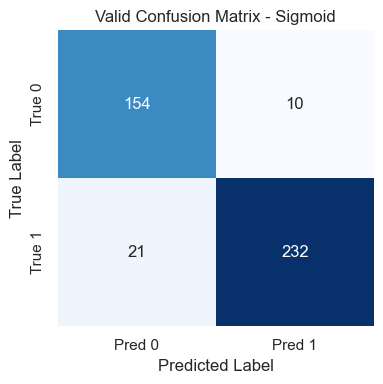

Valid

[Isotonic] Best Threshold: 0.30 (F1: 0.9374)
[Isotonic] Accuracy: 0.9256594724220624
[Isotonic] Brier Score: 0.057778939755463804
[Isotonic] Confusion Matrix:
 [[154  10]
 [ 21 232]]
[Isotonic] Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       164
           1       0.96      0.92      0.94       253

    accuracy                           0.93       417
   macro avg       0.92      0.93      0.92       417
weighted avg       0.93      0.93      0.93       417



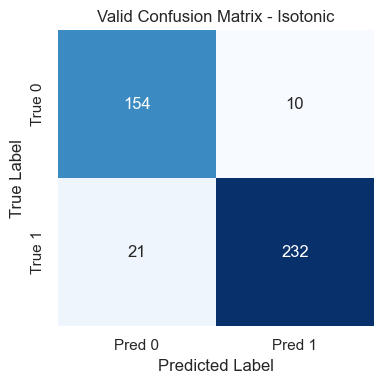

In [ ]:
calib_sigmoid.fit(X_valid, y_valid)
calib_isotonic.fit(X_valid, y_valid)

# ÌôïÎ•† ÏòàÏ∏°
proba_sigmoid_valid = calib_sigmoid.predict_proba(X_valid)[:, 1]
proba_isotonic_valid = calib_isotonic.predict_proba(X_valid)[:, 1]

# threshold ÏµúÏ†ÅÌôî Ìï®Ïàò
def find_best_threshold(y_true, proba):
    thresholds = np.arange(0.30, 0.70, 0.01)
    best_thresh, best_f1 = 0.5, 0
    for t in thresholds:
        y_pred = (proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_thresh, best_f1 = t, f1
    return best_thresh, best_f1

# ÌèâÍ∞Ä Î∞è confusion matrix ÏãúÍ∞ÅÌôî
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

for name, proba in [('Sigmoid', proba_sigmoid_valid), ('Isotonic', proba_isotonic_valid)]:
    thresh, best_f1 = find_best_threshold(y_valid, proba)
    y_pred = (proba >= thresh).astype(int)

    print("Valid")
    print(f"\n[{name}] Best Threshold: {thresh:.2f} (F1: {best_f1:.4f})")
    print(f"[{name}] Accuracy:", accuracy_score(y_valid, y_pred))
    print(f"[{name}] Brier Score:", brier_score_loss(y_valid, proba))
    print(f"[{name}] Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
    print(f"[{name}] Classification Report:\n", classification_report(y_valid, y_pred))

    # üîç Confusion Matrix ÏãúÍ∞ÅÌôî
    plot_conf_matrix(y_valid, y_pred, f"Valid Confusion Matrix - {name}")

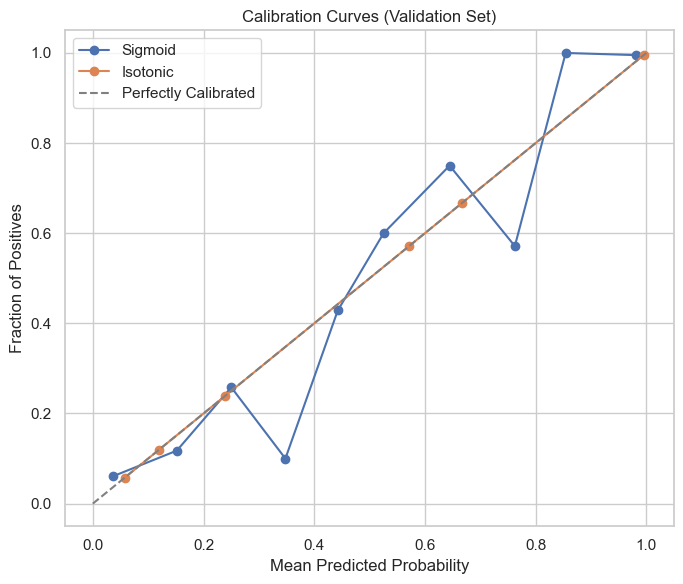

In [ ]:
# Calibration Curve ÏãúÍ∞ÅÌôî
plt.figure(figsize=(7, 6))
for proba, label in zip([proba_sigmoid_valid, proba_isotonic_valid], ['Sigmoid', 'Isotonic']):
    prob_true, prob_pred = calibration_curve(y_valid, proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'{label}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

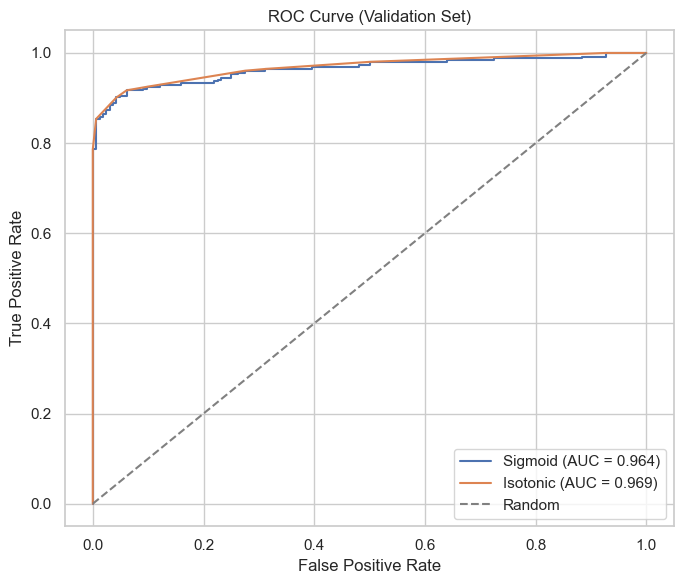

In [ ]:
# Validation AUC Î∞è ROC Curve
plt.figure(figsize=(7, 6))

for proba, label in zip([proba_sigmoid_valid, proba_isotonic_valid], ['Sigmoid', 'Isotonic']):
    auc = roc_auc_score(y_valid, proba)
    fpr, tpr, _ = roc_curve(y_valid, proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## test

Test

[Sigmoid] Test Best Threshold: 0.42 (F1: 0.8974)
[Sigmoid] Test Accuracy: 0.8953771289537713
[Sigmoid] Test Brier Score: 0.0782919913579135
[Sigmoid] Test Confusion Matrix:
 [[180  19]
 [ 24 188]]
[Sigmoid] Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       199
           1       0.91      0.89      0.90       212

    accuracy                           0.90       411
   macro avg       0.90      0.90      0.90       411
weighted avg       0.90      0.90      0.90       411



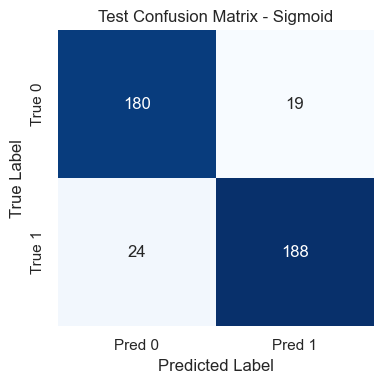

Test

[Isotonic] Test Best Threshold: 0.48 (F1: 0.8964)
[Isotonic] Test Accuracy: 0.8953771289537713
[Isotonic] Test Brier Score: 0.07951534346479995
[Isotonic] Test Confusion Matrix:
 [[182  17]
 [ 26 186]]
[Isotonic] Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89       199
           1       0.92      0.88      0.90       212

    accuracy                           0.90       411
   macro avg       0.90      0.90      0.90       411
weighted avg       0.90      0.90      0.90       411



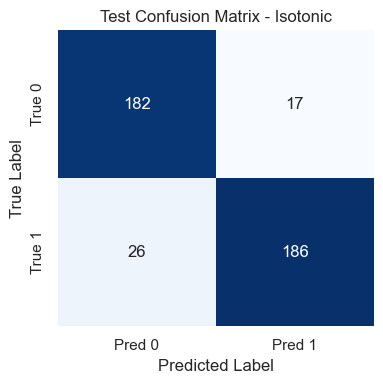

In [ ]:
# ÌôïÎ•† ÏòàÏ∏° (ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏)
proba_sigmoid_test = calib_sigmoid.predict_proba(X_test)[:, 1]
proba_isotonic_test = calib_isotonic.predict_proba(X_test)[:, 1]

# Í∞Å Î≥¥Ï†ï Î™®Îç∏Ïóê ÎåÄÌï¥ threshold Ïû¨ÌÉêÏÉâ (optional)
def find_best_threshold(y_true, proba):
    thresholds = np.arange(0.30, 0.70, 0.01)
    best_thresh, best_f1 = 0.5, 0
    for t in thresholds:
        y_pred = (proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_thresh, best_f1 = t, f1
    return best_thresh, best_f1

# ÌÖåÏä§Ìä∏ ÌèâÍ∞Ä Ïã§Ìñâ
for name, proba in [('Sigmoid', proba_sigmoid_test), ('Isotonic', proba_isotonic_test)]:
    thresh, best_f1 = find_best_threshold(y_test, proba)
    y_pred = (proba >= thresh).astype(int)

    print("Test")
    print(f"\n[{name}] Test Best Threshold: {thresh:.2f} (F1: {best_f1:.4f})")
    print(f"[{name}] Test Accuracy:", accuracy_score(y_test, y_pred))
    print(f"[{name}] Test Brier Score:", brier_score_loss(y_test, proba))
    print(f"[{name}] Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"[{name}] Test Classification Report:\n", classification_report(y_test, y_pred))

    plot_conf_matrix(y_test, y_pred, f"Test Confusion Matrix - {name}")

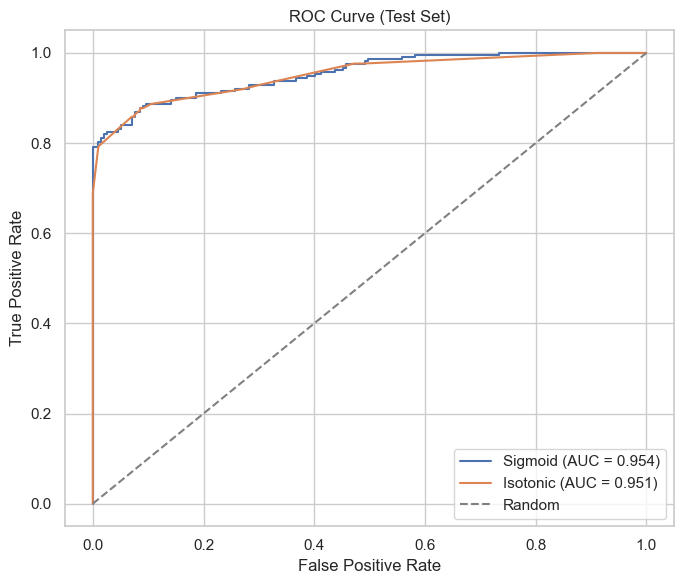

In [ ]:
# Test AUC Î∞è ROC Curve
plt.figure(figsize=(7, 6))

for proba, label in zip([proba_sigmoid_test, proba_isotonic_test], ['Sigmoid', 'Isotonic']):
    auc = roc_auc_score(y_test, proba)
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print("Validation AUC (Sigmoid):", roc_auc_score(y_valid, proba_sigmoid_valid))
print("Validation AUC (Isotonic):", roc_auc_score(y_valid, proba_isotonic_valid))

print("Test AUC (Sigmoid):", roc_auc_score(y_test, proba_sigmoid_test))
print("Test AUC (Isotonic):", roc_auc_score(y_test, proba_isotonic_test))

Validation AUC (Sigmoid): 0.9637761496192037
Validation AUC (Isotonic): 0.9689096693338475
Test AUC (Sigmoid): 0.9538020290129895
Test AUC (Isotonic): 0.9507324357637242
mfv AUC (Sigmoid): 0.962262804965045
mfv AUC (Isotonic): 0.9589099728919959


# 4. Eval

In [ ]:
# corr, VIF, PCA, SHAP

# 5. Prediction

In [ ]:
# 1. summarize

# mean, max, mode col -> top/bot ÌôïÏû•
def expand_topbot(base_cols):
    return [f"{col}_top" for col in base_cols] + [f"{col}_bot" for col in base_cols]

# Ï†ÅÏö©
mean_cols_topbot = expand_topbot(mean_cols)
max_cols_topbot = expand_topbot(max_cols)
mode_cols_topbot = expand_topbot(mode_cols)

print("mean_cols_topbot len : " + str(len(mean_cols_topbot)))
print("max_cols_topbot len : " + str(len(max_cols_topbot)))
print("mode_cols_topbot len : " + str(len(mode_cols_topbot)))


mean_cols_topbot len : 80
max_cols_topbot len : 10
mode_cols_topbot len : 16


In [ ]:
def summarize_prediction_feature(group: pd.DataFrame) -> pd.Series:
    summary = {}

    for col in mean_cols_topbot:
        summary[col] = group[col].mean()

    for col in max_cols_topbot:
        summary[col] = group[col].max()

    for col in mode_cols_topbot:
        summary[col] = safe_mode(group[col])  # Í∏∞Ï°¥Ïóê Ï†ïÏùòÌïú mode Ìï®Ïàò ÏÇ¨Ïö©

    return pd.Series(summary)

fv_a_summary = summarize_prediction_feature(X_fv_a_home)
fv_b_summary = summarize_prediction_feature(X_fv_b_away)

# summarize()Î°ú ÏïïÏ∂ïÎêú SeriesÏù¥Í∏∞ ÎïåÎ¨∏Ïóê 1Ï∞®Ïõê ÌòïÌÉúÎùºÏÑú, Î™®Îç∏ ÏûÖÎ†• Ï†ÑÏóê .to_frame().TÎ°ú 2Ï∞®ÏõêÏúºÎ°ú Î≥ÄÌôò
fv_a = fv_a_summary.to_frame().T
fv_b = fv_b_summary.to_frame().T

display(fv_a)
display(fv_b)

vz0_top  game_type_R_top  p_throws_R_top  bat_score_diff_top  age_pit_top  \
0 -3.617581              1.0        0.895793           -0.693616    28.334814   

   release_pos_z_top  p_throws_L_top  pfx_x_top  \
0           5.746268        0.104207  -0.355493   

   batter_days_since_prev_game_top  of_fielding_alignment_Strategic_top  ...  \
0                         1.444925                             0.004319  ...   

   zone_top  strikes_top  pitch_name_bot  outs_when_up_bot  balls_bot  \
0       9.0          0.0             0.0               1.0        0.0   

   speed_gap_diff_1_bot  pitch_type_bot  type_bot  zone_bot  strikes_bot  
0                  -0.2             6.0       1.0      12.0          0.0  

[1 rows x 106 columns]

vz0_top  game_type_R_top  p_throws_R_top  bat_score_diff_top  age_pit_top  \
0 -3.298557              1.0         0.71684            0.389402    27.893804   

   release_pos_z_top  p_throws_L_top  pfx_x_top  \
0           5.856095         0.28316  -0.078356   

   batter_days_since_prev_game_top  of_fielding_alignment_Strategic_top  ...  \
0                         1.328459                             0.011066  ...   

   zone_top  strikes_top  pitch_name_bot  outs_when_up_bot  balls_bot  \
0      12.0          0.0             0.0               0.0        0.0   

   speed_gap_diff_1_bot  pitch_type_bot  type_bot  zone_bot  strikes_bot  
0                  -0.1             6.0       1.0      12.0          0.0  

[1 rows x 106 columns]

In [ ]:
# 2. is_pitch

pitch_features = [
    'release_speed',  # Ìà¨Íµ¨ ÏÜçÎèÑ (Ìà¨Ïàò Î¶¥Î¶¨Ïä§ ÏãúÏ†ê)
    'release_pos_x',  # Ìà¨Ïàò Î¶¥Î¶¨Ïä§ ÏúÑÏπò (Ï¢åÏö∞)
    'release_pos_z',  # Ìà¨Ïàò Î¶¥Î¶¨Ïä§ ÏúÑÏπò (ÎÜíÏù¥)
    'release_pos_y',  # Ìà¨Ïàò Î¶¥Î¶¨Ïä§ ÏúÑÏπò (ÌôàÍ≥ºÏùò Í±∞Î¶¨)
    'pfx_x',  # Ìà¨Íµ¨Ïùò Ï¢åÏö∞ Î≥ÄÌôîÎüâ
    'pfx_z',  # Ìà¨Íµ¨Ïùò ÏÉÅÌïò Î≥ÄÌôîÎüâ
    'vx0',  # Ìà¨Íµ¨ Ï¥àÍ∏∞ ÏÜçÎèÑ xÏ∂ï ÏÑ±Î∂Ñ
    'vy0',  # Ìà¨Íµ¨ Ï¥àÍ∏∞ ÏÜçÎèÑ yÏ∂ï ÏÑ±Î∂Ñ
    'vz0',  # Ìà¨Íµ¨ Ï¥àÍ∏∞ ÏÜçÎèÑ zÏ∂ï ÏÑ±Î∂Ñ
    'ax',  # Ìà¨Íµ¨ Í∞ÄÏÜçÎèÑ xÏ∂ï
    'ay',  # Ìà¨Íµ¨ Í∞ÄÏÜçÎèÑ yÏ∂ï
    'az',  # Ìà¨Íµ¨ Í∞ÄÏÜçÎèÑ zÏ∂ï
    'effective_speed',  # ÌÉÄÏûêÍ∞Ä ÎäêÎÅºÎäî Ïã§ÏßàÏ†ÅÏù∏ Í≥µÏùò ÏÜçÎèÑ
    'release_spin_rate',  # Î¶¥Î¶¨Ïä§ ÏàúÍ∞ÑÏùò ÌöåÏ†ÑÏàò
    'release_extension',  # Î¶¥Î¶¨Ïä§ ÏßÄÏ†êÍ≥º ÌôàÌîåÎ†àÏù¥Ìä∏ ÏÇ¨Ïù¥ Í±∞Î¶¨
    'spin_axis',  # Í≥µÏùò ÌöåÏ†ÑÏ∂ï (Íµ¨ÏßàÏùò Î∞©Ìñ•ÏÑ±)
    'arm_angle',  # Ìà¨Ïàò ÌåîÏùò Î¶¥Î¶¨Ïä§ Í∞ÅÎèÑ
    'age_pit',  # Ìà¨Ïàò ÎÇòÏù¥
    'pitcher_days_since_prev_game',  # Ìà¨ÏàòÏùò ÎßàÏßÄÎßâ Îì±Ìåê Ïù¥ÌõÑ Ìú¥ÏãùÏùº Ïàò
    'api_break_z_with_gravity',  # Ï§ëÎ†• Ìè¨Ìï® Ìà¨Íµ¨ ÎÇôÌè≠ (ÎÇôÏ∞®)
    'api_break_x_arm',  # Ìà¨Ïàò Í∏∞Ï§Ä Ï¢åÏö∞ Î≥ÄÌôîÎüâ
    'p_throws_L',  # Ìà¨ÏàòÍ∞Ä ÏôºÏÜêÏû°Ïù¥Ïù∏ÏßÄ Ïó¨Î∂Ä (One-hot)
    'p_throws_R',  # Ìà¨ÏàòÍ∞Ä Ïò§Î•∏ÏÜêÏû°Ïù¥Ïù∏ÏßÄ Ïó¨Î∂Ä (One-hot)
    'game_type_R',  # Í≤ΩÍ∏∞ ÌÉÄÏûÖÏù¥ Ï†ïÍ∑úÏãúÏ¶å(R)Ïù∏ÏßÄ Ïó¨Î∂Ä (Ï†ïÍ∑ú Î©îÌÉÄÏ†ïÎ≥¥)
    'n_thruorder_pitcher',  # Ìï¥Îãπ Ìà¨ÏàòÍ∞Ä ÌÉÄÏûê ÎùºÏù∏ÏóÖÏùÑ Î™á Î≤àÏß∏ ÎèÑÎäî Ï§ëÏù∏ÏßÄ
    'if_fielding_alignment_Standard',  # ÎÇ¥Ïïº ÏàòÎπÑ Ïä§ÌÉ†Îã§Îìú Ïó¨Î∂Ä
    'if_fielding_alignment_Strategic',  # ÎÇ¥Ïïº ÏàòÎπÑ Ï†ÑÎûµÏ†Å Î∞∞Ïπò Ïó¨Î∂Ä
    'of_fielding_alignment_Standard',  # Ïô∏Ïïº ÏàòÎπÑ Ïä§ÌÉ†Îã§Îìú Ïó¨Î∂Ä
    'of_fielding_alignment_Strategic'  # Ïô∏Ïïº ÏàòÎπÑ Ï†ÑÎûµÏ†Å Î∞∞Ïπò Ïó¨Î∂Ä
]

swing_features = [
    'plate_x',  # Í≥µÏù¥ ÌôàÌîåÎ†àÏù¥Ìä∏ Í∏∞Ï§Ä Ï¢åÏö∞ Ïñ¥ÎîîÎ•º ÌÜµÍ≥ºÌñàÎäîÏßÄ
    'plate_z',  # Í≥µÏù¥ ÌôàÌîåÎ†àÏù¥Ìä∏ Í∏∞Ï§Ä Ïñ¥Îäê ÎÜíÏù¥Î•º ÌÜµÍ≥ºÌñàÎäîÏßÄ
    'balls',  # ÌòÑÏû¨ Î≥º Ïπ¥Ïö¥Ìä∏
    'strikes',  # ÌòÑÏû¨ Ïä§Ìä∏ÎùºÏù¥ÌÅ¨ Ïπ¥Ïö¥Ìä∏
    'outs_when_up',  # ÌÉÄÏÑù ÏãúÏ†ê ÏïÑÏõÉ Ïπ¥Ïö¥Ìä∏
    'bat_score_diff',  # ÌÉÄÏÑù ÏãúÏ†ê Ï†êÏàòÏ∞® (ÌÉÄÏûê ÌåÄ Í∏∞Ï§Ä)
    'api_break_x_batter_in',  # ÌÉÄÏûê Í∏∞Ï§ÄÏúºÎ°ú Î™∏Ï™ΩÏúºÎ°ú ÌúòÎäî Ï†ïÎèÑ
    'age_bat',  # ÌÉÄÏûê ÎÇòÏù¥
    'batter_days_since_prev_game',  # ÌÉÄÏûêÏùò ÎßàÏßÄÎßâ Ï∂úÏ†Ñ Ïù¥ÌõÑ Ìú¥ÏãùÏùº Ïàò
    'stand_L',  # ÌÉÄÏûêÍ∞Ä ÏôºÏÜêÏû°Ïù¥Ïù∏ÏßÄ Ïó¨Î∂Ä (One-hot)
    'stand_R',  # ÌÉÄÏûêÍ∞Ä Ïò§Î•∏ÏÜêÏû°Ïù¥Ïù∏ÏßÄ Ïó¨Î∂Ä (One-hot)
    'at_bat_number',  # Ïù¥ Í≤ΩÍ∏∞ÏóêÏÑúÏùò ÌÉÄÏÑù Î≤àÌò∏
    'n_priorpa_thisgame_player_at_bat',  # Ïù¥ Í≤ΩÍ∏∞ÏóêÏÑúÏùò ÌÉÄÏûêÏùò Ïù¥Ï†Ñ ÌÉÄÏÑù Ïàò
    'pitch_type',  # Ìà¨Íµ¨ ÌÉÄÏûÖ ÏΩîÎìú (ex. 'FF' Îì±)
    'zone',  # Ïä§Ìä∏ÎùºÏù¥ÌÅ¨ Ï°¥ Î≤àÌò∏ (1~14)
    'type',  # Í≤∞Í≥º ÌÉÄÏûÖ (B: Î≥º, S: Ïä§Ìä∏ÎùºÏù¥ÌÅ¨, X: Ïù∏ÌîåÎ†àÏù¥)
    'pitch_name',  # Íµ¨Ïßà Î™ÖÏπ≠ (ex. 4-Seam Fastball)
    'sz_top',  # ÌÉÄÏûê Í∏∞Ï§Ä Ïä§Ìä∏ÎùºÏù¥ÌÅ¨ Ï°¥ ÏÉÅÎã®
    'sz_bot'   # ÌÉÄÏûê Í∏∞Ï§Ä Ïä§Ìä∏ÎùºÏù¥ÌÅ¨ Ï°¥ ÌïòÎã®
]
'''
taf_pitch_cols = [
    'spin_efficiency_rolling_avg_5', 'spin_efficiency_lag_1', 'spin_efficiency_diff_1',
    'speed_gap_rolling_avg_5', 'speed_gap_lag_1', 'speed_gap_diff_1',
    'release_pos_angle_rolling_avg_5', 'release_pos_angle_lag_1', 'release_pos_angle_diff_1',
    'init_velocity_vector_rolling_avg_5', 'init_velocity_vector_lag_1', 'init_velocity_vector_diff_1',
    'pitch_movement_vector_rolling_avg_5', 'pitch_movement_vector_lag_1', 'pitch_movement_vector_diff_1',
    'speed_per_extension_rolling_avg_5', 'speed_per_extension_lag_1', 'speed_per_extension_diff_1',
    'release_mechanics_profile_rolling_avg_5', 'release_mechanics_profile_lag_1', 'release_mechanics_profile_diff_1',
    'vertical_spin_effect_rolling_avg_5', 'vertical_spin_effect_lag_1', 'vertical_spin_effect_diff_1',
    'horizontal_spin_effect_rolling_avg_5', 'horizontal_spin_effect_lag_1', 'horizontal_spin_effect_diff_1'
]
taf_swing_cols = [
    'plate_distance_rolling_avg_5', 'plate_distance_lag_1', 'plate_distance_diff_1'
]
'''

# pitch/swing Íµ¨Î∂Ñ ÌÇ§ÏõåÎìú Ï†ïÏùò (Í∏∞Ï§Ä ÌÇ§ÏõåÎìú)
pitch_keywords = [
    'spin_efficiency', 'speed_gap', 'release_pos_angle',
    'init_velocity_vector', 'pitch_movement_vector',
    'speed_per_extension', 'release_mechanics_profile',
    'vertical_spin_effect', 'horizontal_spin_effect'
]
swing_keywords = ['plate_distance']

# selected_taf_colsÎ•º Í∏∞Ï§ÄÏúºÎ°ú Î∂ÑÎ•ò
taf_pitch_cols = [col for col in selected_taf_cols if any(key in col for key in pitch_keywords)]
taf_swing_cols = [col for col in selected_taf_cols if any(key in col for key in swing_keywords)]

# pitch/swing feature ÌôïÏû•
pitch_features += taf_pitch_cols
swing_features += taf_swing_cols

# ÌôïÏù∏
print(f"üìå pitch_features Ï¥ù Í∞úÏàò: {len(pitch_features)}")
print(f"üìå swing_features Ï¥ù Í∞úÏàò: {len(swing_features)}")

print("\nüéØ Ï∂îÍ∞ÄÎêú TAF pitch features:")
print(taf_pitch_cols)

print("\nüéØ Ï∂îÍ∞ÄÎêú TAF swing features:")
print(taf_swing_cols)


üìå pitch_features Ï¥ù Í∞úÏàò: 33
üìå swing_features Ï¥ù Í∞úÏàò: 20

üéØ Ï∂îÍ∞ÄÎêú TAF pitch features:
['spin_efficiency_rolling_avg_5', 'speed_gap_diff_1', 'pitch_movement_vector_rolling_avg_5', 'vertical_spin_effect_lag_1']

üéØ Ï∂îÍ∞ÄÎêú TAF swing features:
[]


In [ ]:
# Ï†ÑÏ≤¥ feature Î¶¨Ïä§Ìä∏ (fv_a.columns Î°úÎ∂ÄÌÑ∞)
all_features = fv_a.columns.tolist()

def filter_for_prediction(fv_row: pd.DataFrame, mode: str, pitch_features, swing_features):
    assert mode in ['home', 'away'], "mode must be 'home' or 'away'"
    
    # Ï†ÑÏ≤¥ feature Î¶¨Ïä§Ìä∏
    all_features = fv_row.columns.tolist()

    # pitch/swing Ï†ÑÏ≤¥ top/bot Ïª¨ÎüºÎ™Ö
    pitch_features_tb = [f"{feat}_{suffix}" for feat in pitch_features for suffix in ['top', 'bot']]
    swing_features_tb = [f"{feat}_{suffix}" for feat in swing_features for suffix in ['top', 'bot']]

    # Í∞Å featureÍ∞Ä pitchÏù∏ÏßÄ Ïó¨Î∂Ä
    is_pitch = [feat in pitch_features_tb for feat in all_features]

    # ÌïÑÌÑ∞ Ï°∞Í±¥ Íµ¨ÏÑ±
    keep_mask = []
    for col, pitch_flag in zip(all_features, is_pitch):
        if mode == 'home':
            if col.endswith('_top') and pitch_flag:
                keep_mask.append(True)  # pitch_top ‚Üí ÎÇ®Í∏¥Îã§
                
            elif col.endswith('_bot') and not pitch_flag:
                keep_mask.append(True)  # swing_bot ‚Üí ÎÇ®Í∏¥Îã§
                
            else:
                keep_mask.append(False) # ÎÇòÎ®∏ÏßÄÎäî Ï†úÍ±∞
                
        elif mode == 'away':
            if col.endswith('_top') and not pitch_flag: 
                keep_mask.append(True) # swing_top ‚Üí ÎÇ®Í∏¥Îã§
                
            elif col.endswith('_bot') and pitch_flag: 
                keep_mask.append(True) # pitch_bot ‚Üí ÎÇ®Í∏¥Îã§
                
            else:
                keep_mask.append(False) # ÎÇòÎ®∏ÏßÄÎäî Ï†úÍ±∞

    # ÌïÑÌÑ∞ÎßÅ Ï†ÅÏö©
    filtered_row = fv_row.loc[:, keep_mask]

    return filtered_row

fv_a_filtered = filter_for_prediction(fv_a, mode='home', pitch_features=pitch_features, swing_features=swing_features)
fv_b_filtered = filter_for_prediction(fv_b, mode='away', pitch_features=pitch_features, swing_features=swing_features)

In [ ]:
display(fv_a_filtered)
display(fv_b_filtered)

'''
# feature-value ÏåçÏúºÎ°ú Î≥ÄÌôò
fv_compare = pd.DataFrame({
    'fv_a_feature': fv_a_filtered.columns,
    'fv_a_value': fv_a_filtered.iloc[0].values,
    'fv_b_feature': fv_b_filtered.columns,
    'fv_b_value': fv_b_filtered.iloc[0].values
})

# ExcelÎ°ú Ï†ÄÏû• (ÎèôÏùº ÏãúÌä∏)
fv_compare.to_excel("fv_filtered.xlsx", sheet_name="fv_compare", index=False)
'''

vz0_top  game_type_R_top  p_throws_R_top  age_pit_top  release_pos_z_top  \
0 -3.617581              1.0        0.895793    28.334814           5.746268   

   p_throws_L_top  pfx_x_top  of_fielding_alignment_Strategic_top  \
0        0.104207  -0.355493                             0.004319   

   api_break_z_with_gravity_top  spin_axis_top  ...  \
0                       2.04765     193.176338  ...   

   n_priorpa_thisgame_player_at_bat_bot  pitch_number_bot  \
0                                   5.0              15.0   

   speed_gap_diff_1_top  pitch_name_bot  outs_when_up_bot  balls_bot  \
0                   0.0             0.0               1.0        0.0   

   pitch_type_bot  type_bot  zone_bot  strikes_bot  
0             6.0       1.0      12.0          0.0  

[1 rows x 53 columns]

bat_score_diff_top  batter_days_since_prev_game_top  sz_bot_top  \
0            0.389402                         1.328459    1.588022   

   plate_x_top  plate_z_top  stand_L_top  stand_R_top  age_bat_top  \
0     0.003324     2.441196     0.512697     0.487303    27.422625   

   api_break_x_batter_in_top  sz_top_top  ...  n_thruorder_pitcher_bot  \
0                    -0.2104    3.418816  ...                      3.0   

   vertical_spin_effect_lag_1_bot  pitch_name_top  outs_when_up_top  \
0                           413.7             0.0               2.0   

   balls_top  pitch_type_top  type_top  zone_top  strikes_top  \
0        0.0             6.0       1.0      12.0          0.0   

   speed_gap_diff_1_bot  
0                  -0.1  

[1 rows x 53 columns]

'\n# feature-value ÏåçÏúºÎ°ú Î≥ÄÌôò\nfv_compare = pd.DataFrame({\n    \'fv_a_feature\': fv_a_filtered.columns,\n    \'fv_a_value\': fv_a_filtered.iloc[0].values,\n    \'fv_b_feature\': fv_b_filtered.columns,\n    \'fv_b_value\': fv_b_filtered.iloc[0].values\n})\n\n# ExcelÎ°ú Ï†ÄÏû• (ÎèôÏùº ÏãúÌä∏)\nfv_compare.to_excel("fv_filtered.xlsx", sheet_name="fv_compare", index=False)\n'

In [ ]:
# 3. concat

# Ïª¨Îüº Î∞©Ìñ•ÏúºÎ°ú Í≤∞Ìï© ‚Üí shape: (1, 102)
fv = pd.concat([fv_a_filtered, fv_b_filtered], axis=1)
fv

# ÌïôÏäµ ÎãπÏãú feature ÏàúÏÑúÎ°ú Ïû¨Ï†ïÎ†¨
fv_reindex = fv.reindex(columns=feature_order)
fv_reindex

display(fv)
display(fv_reindex)

'''
# feature-value ÏåçÏúºÎ°ú Î≥ÄÌôò
fv_compare = pd.DataFrame({
    'fv_feature': fv.columns,
    'fv_value': fv.iloc[0].values,
    'fv_reindex_feature': fv_reindex.columns,
    'fv_reindex_value': fv_reindex.iloc[0].values
})

# ExcelÎ°ú Ï†ÄÏû• (ÎèôÏùº ÏãúÌä∏)
fv_compare.to_excel("fv.xlsx", sheet_name="fv_compare", index=False)
'''

vz0_top  game_type_R_top  p_throws_R_top  age_pit_top  release_pos_z_top  \
0 -3.617581              1.0        0.895793    28.334814           5.746268   

   p_throws_L_top  pfx_x_top  of_fielding_alignment_Strategic_top  \
0        0.104207  -0.355493                             0.004319   

   api_break_z_with_gravity_top  spin_axis_top  ...  n_thruorder_pitcher_bot  \
0                       2.04765     193.176338  ...                      3.0   

   vertical_spin_effect_lag_1_bot  pitch_name_top  outs_when_up_top  \
0                           413.7             0.0               2.0   

   balls_top  pitch_type_top  type_top  zone_top  strikes_top  \
0        0.0             6.0       1.0      12.0          0.0   

   speed_gap_diff_1_bot  
0                  -0.1  

[1 rows x 106 columns]

vz0_top  vz0_bot  game_type_R_top  game_type_R_bot  p_throws_R_top  \
0 -3.617581 -4.14491              1.0              1.0        0.895793   

   p_throws_R_bot  bat_score_diff_top  bat_score_diff_bot  age_pit_top  \
0        0.773349            0.389402            0.460441    28.334814   

   age_pit_bot  ...  speed_gap_diff_1_top  speed_gap_diff_1_bot  \
0    28.605289  ...                   0.0                  -0.1   

   pitch_type_top  pitch_type_bot  type_top  type_bot  zone_top  zone_bot  \
0             6.0             6.0       1.0       1.0      12.0      12.0   

   strikes_top  strikes_bot  
0          0.0          0.0  

[1 rows x 106 columns]

'\n# feature-value ÏåçÏúºÎ°ú Î≥ÄÌôò\nfv_compare = pd.DataFrame({\n    \'fv_feature\': fv.columns,\n    \'fv_value\': fv.iloc[0].values,\n    \'fv_reindex_feature\': fv_reindex.columns,\n    \'fv_reindex_value\': fv_reindex.iloc[0].values\n})\n\n# ExcelÎ°ú Ï†ÄÏû• (ÎèôÏùº ÏãúÌä∏)\nfv_compare.to_excel("fv.xlsx", sheet_name="fv_compare", index=False)\n'

## Single Match

In [ ]:
'''
calib_sigmoid
calib_isotonic
'''

# ÏòàÏ∏°
proba_sigmoid = calib_sigmoid.predict_proba(fv_reindex)[0]
proba_isotonic = calib_isotonic.predict_proba(fv_reindex)[0]
# Ïù¥Í±¥ fvÍ∞Ä ÌïòÎÇòÏùò ÏÉòÌîå(1 row)Ïù¥ÎØÄÎ°ú, predict_proba(fv) Í≤∞Í≥ºÎäî (1, 2) shapeÏùò Î∞∞Ïó¥ÏûÖÎãàÎã§.
# [0]ÏùÑ Î∂ôÏù¥Î©¥ Í∑∏ Ï§ë Ï≤´ Î≤àÏß∏ (Í∑∏Î¶¨Í≥† Ïú†ÏùºÌïú) rowÏù∏ ÌôïÎ•† Î≤°ÌÑ∞ ex) [0.36, 0.64]Î•º Í∫ºÎÉÖÎãàÎã§.

In [ ]:
print(f"proba_sigmoid win probability")
print(f"{pred_month}/{pred_date} {a}(Home) {proba_sigmoid[1]:.2f} : {b}(Away) {proba_sigmoid[0]:.2f}")
print()
print(f"proba_isotonic win probability")
print(f"{pred_month}/{pred_date} {a}(Home) {proba_isotonic[1]:.2f} : {b}(Away) {proba_isotonic[0]:.2f}")

proba_sigmoid win probability
6/2025-06-21 00:00:00 TB(Home) 0.74 : DET(Away) 0.26

proba_isotonic win probability
6/2025-06-21 00:00:00 TB(Home) 0.67 : DET(Away) 0.33


## Multiple Match

In [ ]:
# 1. Feature + Meta Î∂àÎü¨Ïò§Í∏∞

# 2. Meta Î∂ÑÎ¶¨ (Ïª¨ÎüºÎ™ÖÏùÄ Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Ïóê ÎßûÍ≤å Ï°∞Ï†ïÌïòÏÑ∏Ïöî)
meta_cols = [
 'home_team',
 'away_team',
 'game_date',
 'label']

meta = df[meta_cols]
y_true = meta['label']

X_fv = df.drop(columns=meta_cols)

# 3. feature Ï†ïÎ†¨ (ÌïôÏäµ Ïãú feature ÏàúÏÑúÎåÄÎ°ú)
X_fv = X_fv.reindex(columns=feature_order)

KeyError: "None of [Index(['home_team', 'away_team', 'game_date', 'label'], dtype='object')] are in the [columns]"

In [ ]:
# 4. ÏòàÏ∏°
y_pred_sigmoid = calib_sigmoid.predict_proba(X_fv)
y_pred_isotonic = calib_isotonic.predict_proba(X_fv)

# 5. Í≤∞Í≥º Ï†ïÎ¶¨
meta = meta.reset_index(drop=True)  # ÏïàÏ†ÑÌïòÍ≤å
result_df = meta.copy()
result_df['home_win_proba_sigmoid'] = y_pred_sigmoid[:, 1]  # [home ÌôïÎ•†]
result_df['home_win_proba_isotonic'] = y_pred_isotonic[:, 1]


'''# Í≤∞Í≥º CSVÎ°ú Ï†ÄÏû•
result_df.to_csv("prediction_results_20250601_0619.csv", index=False)'''

'# Í≤∞Í≥º CSVÎ°ú Ï†ÄÏû•\nresult_df.to_csv("prediction_results_20250601_0619.csv", index=False)'


[Sigmoid Calibration] Threshold: 0.50
[Sigmoid Calibration] Accuracy: 0.5622
[Sigmoid Calibration] Confusion Matrix:
[[55 36]
 [52 58]]
[Sigmoid Calibration] Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.60      0.56        91
           1       0.62      0.53      0.57       110

    accuracy                           0.56       201
   macro avg       0.57      0.57      0.56       201
weighted avg       0.57      0.56      0.56       201



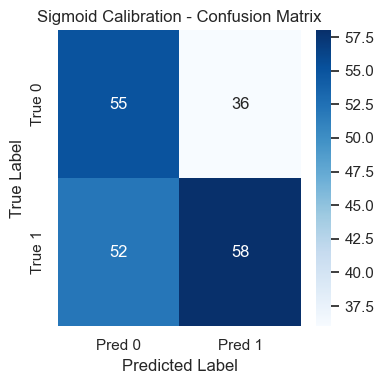


[Isotonic Calibration] Threshold: 0.50
[Isotonic Calibration] Accuracy: 0.5622
[Isotonic Calibration] Confusion Matrix:
[[55 36]
 [52 58]]
[Isotonic Calibration] Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.60      0.56        91
           1       0.62      0.53      0.57       110

    accuracy                           0.56       201
   macro avg       0.57      0.57      0.56       201
weighted avg       0.57      0.56      0.56       201



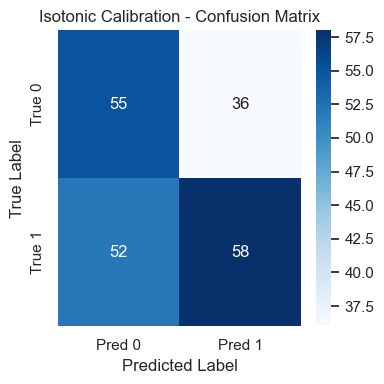

In [ ]:
def evaluate_predictions(y_true, y_proba, threshold=0.5, title="General"):
    """
    y_true: Ïã§Ï†ú ÎùºÎ≤® (0 ÎòêÎäî 1)
    y_proba: Î™®Îç∏Ïùò ÌôïÎ•† ÏòàÏ∏° (0.0 ~ 1.0)
    threshold: Î∂ÑÎ•ò ÏûÑÍ≥ÑÍ∞í
    title: ÏãúÍ∞ÅÌôî Ï†úÎ™©Ïö© ÌÖçÏä§Ìä∏
    """
    y_pred = (y_proba >= threshold).astype(int)

    print("General")
    print(f"\n[{title}] Threshold: {threshold:.2f}")
    print(f"[{title}] Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"[{title}] Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"[{title}] Classification Report:\n{classification_report(y_true, y_pred)}")

    # Confusion Matrix ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f"{title} -General Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


# sigmoid ÌèâÍ∞Ä
evaluate_predictions(y_true, y_pred_sigmoid[:, 1], title="Sigmoid Calibration")

# isotonic ÌèâÍ∞Ä
evaluate_predictions(y_true, y_pred_isotonic[:, 1], title="Isotonic Calibration")

